# **[ Building Classification Models with Scikit-learn ]**

## **프로젝트 요약**


> 본 프로젝트의 목적은 손실함수와 경사하강법을 이해하고, 활용해 선형 방정식 형태로 된 모델을 학습시켜 실수형 데이터를 예측하는 선형 회귀분석 프로젝트의 전체 프로세스를 경험하고 익히는 것이다. 여기서 예측(prediction)문제란 입력데이터를 사용하여 정답데이터의 값을 최대한 정답과 가깝게 계산하는 것을 말한다. 예측문제 중에서 정답데이터 값이 연속적인 문제를 회귀분석(regression analasys)라고 한다. </br>
</br>
 **[Project 1. 당뇨병 진행도 예측: 손수 설계하는 선형회귀, 당뇨병 수치를 맞춰보자!]** </br>
회귀분석에 대해서 이해하기 위해서 sklearn패키지에서 제공하는 당뇨병데이터셋을 활용하여 패키지사용없이 직접 손실함수를 정의하고 경사하강법을 구현해보았다. </br>당뇨병 진행도 예측 프로젝트의 목표는 당뇨병 환자의 혈액검사 결과, 개인정보(성별,나이) 등의 정보가 담긴 데이터를 통해 당뇨병의 진행률을 예측하는 것이다. </br>프로젝트는 1)데이터 불러오기 2) 탐색적 데이터 분석 및 전처리 3) 모델 구현 4) 모델 평가 순서로 진행하였다.</br>
</br>
**[Project 2. 자전거 대여량 예측: 날씨 좋은 월요일 오후 세 시, 자전거 타는 사람은 몇 명? ]**
</br>
직접 손실함수와 기울기를 계산하지 않고도 (빠르고 간편하게) 선형회귀를 구현하는 방법을 익히기위해 sklearn의 LinearRegression을 활용해 진행하였다. 데이터는 Kaggle의 Bike Sharing Demand 경진대회에서 제공되는 것을 이용하였다. 해당 프로젝트의 목표는 시간, 온도, 습도, 계절 등의 정보가 담긴 데이터를 통해 자전거의 대여량을 예측하는 것이다. </br>프로젝트는 1)데이터 불러오기 2) 탐색적 데이터 분석 및 전처리 3) 모델 구현 4) 모델 평가 순서로 진행하였다.



## **0. 사전정의**
---

In [690]:
############################################## 라이브러리 불러오기 #####################################################

import copy
import numpy as np
import pandas as pd
import platform
import random
import warnings
warnings.filterwarnings(action = "ignore")
from datetime import datetime, timedelta



# 시각화
import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

if platform.system() == 'Darwin': #맥
    plt.rc('font', family='AppleGothic') 
elif platform.system() == 'Windows': #윈도우
    plt.rc('font', family='Malgun Gothic') 
elif platform.system() == 'Linux': #리눅스 (구글 코랩)    

    ! sudo apt-get update -qq
    ! sudo apt-get install fonts-nanum* -qq #나눔글꼴 설치
    ! sudo fc-cache -fv #폰트캐시 삭제

    # 나눔글꼴 matplotlib에 복사 (파이썬 버전 확인하는것 중요 !)
    ! sudo cp /usr/share/fonts/truetype/nanum/Nanum* /usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/fonts/ttf/
    # matplotlib 캐시삭제
    try:
      ! rm -rf /content/.cache/matplotlib/* #colab
    except:
      ! rm -rf /home/ubuntu/.cache/matplotlib/* #ubuntu


    sys_font=fm.findSystemFonts()
    nanum_font = [f for f in sys_font if 'NanumGothicCoding.ttf' in f][0]
    font_name = fm.FontProperties(fname=nanum_font, size=10).get_name()
    plt.rc('font', family=font_name)


plt.rcParams['axes.unicode_minus'] = False 
# fm._rebuild()

# 데이터셋 
from sklearn.datasets import load_diabetes

# 학습데이터분리, 교차검증
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# ml 알고리즘 

from sklearn.linear_model import LinearRegression


# 모델 성능 평가 지표 

from sklearn.metrics import mean_squared_error



/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 31 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [691]:
############################################## 함수 정의(모델학습,검증,시각화 등을 위한) #####################################################

# 전체 데이터셋 히트맵으로 시각화 
def draw_corrmap(df):
  plt.figure(figsize=(10, 8))
  y_corrmat = df.corr()
  sns.heatmap(y_corrmat, #데이터
              annot = True, #셀값 표기 유무
              annot_kws = {"size": 10}, #셀값 글자크기
              cmap = 'PuBu', #히트맵 색
              cbar = True, #colorbar 유무
              linewidth=3,
              fmt='.2f') # 선굵기


# 특정 컬럼을 기준으로 상관관계가 가장 강한 top n 개를 히트맵으로 시각화 하는 함수 (# df = 데이터프레임 # y = 주요하게 보고 싶은 값 # k = 그 y값으로부터 가장 상관관계가 강한 TOP k개를 보겠다)
def draw_top_corrmap(df,y,k):
  plt.figure(figsize=(8, 6))
  y_corrmat = df.corr()
  y_cols = y_corrmat.nlargest(k, y)[y].index
  cm = np.corrcoef(df[y_cols].values.T)
  hm = sns.heatmap(cm, #데이터
                   annot = True, #셀값 표기 유무
                   annot_kws = {"size": 10}, #셀값 글자크기
                   cmap = 'PuBu', #히트맵 색
                   cbar = True, #colorbar 유무
                   linewidth=3, 
                   fmt='.2f',
                   yticklabels=y_cols.values, 
                   xticklabels=y_cols.values) # 선굵기
  
    


## **Project 1. 당뇨병 진행도 예측: 손수 설계하는 선형회귀, 당뇨병 수치를 맞춰보자!** <a class="anchor" id="chapter1"></a> 
---


### **1-0. 문제 정의**

#### **1-0.1. 프로젝트 목표**  
<div>
본 프로젝트는 회귀분석에 대해서 이해하기 위해서 sklearn패키지에서 제공하는 당뇨병데이터셋을 활용하여 패키지사용없이 직접 손실함수를 정의하고 경사하강법을 구현해보는 것을 목표로한다. <br>해결해야할 문제는 당뇨병 환자의 혈액검사 결과, 개인정보(성별,나이) 등의 정보가 담긴 데이터를 통해 당뇨병의 진행률을 예측하는 것이다.</div>
<div>




#### **1-0.2. 분석 데이터 정의** 
<div> 
데이터는 sklearn.dataset 안에 빌트인 데이터셋으로 제공하는 당뇨병 데이터셋(load_diabetes)을 사용한다. 
해당 데이터셋은 sklearn.utils.Bunch 라는 자료구조를 활용하는데, key-value 형식으로 구성되어 있으며, 딕셔너리 타입과 유사한 구조를 가지고 있다. 
<br>
데이터셋의 세부적인 구성은 아래 표에서 확인할 수 있다. 
<br>
</br>

| 속성 | 설명 |
| --- | --- |
| data | 샘플데이터, 평명화된 (442,10) 크기의 ndarray  |
| target | label 데이터, (442, ) 크기의 ndarray  |
| feature_names | Feature 데이터 이름 |
| DESCR | 데이터 세트에 대한 전체 설명 |

</div> 





#### **1-0.3. 모델링 task 정의**  
<div>
feature들의 값으로 실수형 데이터를 예측하는 선형 회귀에 속한다. 이번에는 패키지사용없이 직접 모델을 구현해야한다. <br> 즉 모델이 출력하는 값과 실제 정답 간의 차이를 계산하기 위해 손실함수를 구현하고, 그 차이를 단계적으로 줄여나가는 경사하강법을 구현하여야한다. 이번 프로젝트에서는 선형회귀를 직접 구현하는데에 초점을 맞추는게 중요하니 eda 및 전처리는 정말 간단하게 진행하고 넘어기로 한다.
</div> 


### **1-1. 데이터 불러오기**

In [637]:
############################## 데이터 로드 & 확인 ##############################

diabetes = load_diabetes()
df_X = diabetes.data
df_y = diabetes.target


diabetes_df = pd.DataFrame(data=df_X, columns=diabetes.feature_names)
diabetes_df['label'] =  df_y
print("################################ 데이터 설명 ##############################\n")
print(diabetes.DESCR)

print("\n############################## 데이터 확인 ##############################\n")
print(f' *샘플데이터 크기 : {df_X.shape}')
print(f' *정답데이터 크기 : {df_y.shape}')

print("\n############################## 데이터프레임 확인 ###########################\n")

diabetes_df.head()

################################ 데이터 설명 ##############################

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycer

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,label
0,0.04,0.05,0.06,0.02,-0.04,-0.03,-0.04,-0.00,0.02,-0.02,151.00
1,-0.00,-0.04,-0.05,-0.03,-0.01,-0.02,0.07,-0.04,-0.07,-0.09,75.00
2,0.09,0.05,0.04,-0.01,-0.05,-0.03,-0.03,-0.00,0.00,-0.03,141.00
3,-0.09,-0.04,-0.01,-0.04,0.01,0.02,-0.04,0.03,0.02,-0.01,206.00
4,0.01,-0.04,-0.04,0.02,0.00,0.02,0.01,-0.00,-0.03,-0.05,135.00


### **1-2. 탐색적 데이터 분석 및 전처리**


#### **1-2-1. 데이터 타입 & 갯수 확인**

In [132]:
############################## 컬럼별 데이터 타입확인 ##############################
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
 10  label   442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB


In [133]:
############################## feature별 unique값 갯수 확인 ##############################
[(f"{col} :", len(diabetes_df[col].unique())) for col in diabetes_df]

[('age :', 58),
 ('sex :', 2),
 ('bmi :', 163),
 ('bp :', 100),
 ('s1 :', 141),
 ('s2 :', 302),
 ('s3 :', 63),
 ('s4 :', 66),
 ('s5 :', 184),
 ('s6 :', 56),
 ('label :', 214)]

데이터타입을 확인해보면 전부 실수형이라 모두 실수형으로 생각할수 있다. 하지만 unique값 갯수 확인을 해보니 sex 값은 범주형값임을 유추해볼 수 있다. (사실 컬럼명으로도 판단이 가능하긴하지만 컬럼명이 c1,c2이렇게 돼있는 경우에는 갯수로 확인해야한다.) 범주형 데이터인데 실수형으로 표시된경우에는 범주형으로 형변환을 시켜주는 경우가 있으나 지금은 형변환은 진행하지않도록한다. 


#### **1-2-2. 통계값 확인**

In [134]:
############################## 컬럼별 간단한 통계값 확인 ##############################
# 지수표현식에서 실수표현식으로 표기하기 위해 실수자릿수 설정
pd.options.display.float_format = '{:.2f}'.format

diabetes_df.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,label
count,442.00,442.00,442.00,442.00,442.00,442.00,442.00,442.00,442.00,442.00,442.00
mean,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,152.13
std,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,77.09
min,-0.11,-0.04,-0.09,-0.11,-0.13,-0.12,-0.10,-0.08,-0.13,-0.14,25.00
25%,-0.04,-0.04,-0.03,-0.04,-0.03,-0.03,-0.04,-0.04,-0.03,-0.03,87.00
50%,0.01,-0.04,-0.01,-0.01,-0.00,-0.00,-0.01,-0.00,-0.00,-0.00,140.50
75%,0.04,0.05,0.03,0.04,0.03,0.03,0.03,0.03,0.03,0.03,211.50
max,0.11,0.05,0.17,0.13,0.15,0.20,0.18,0.19,0.13,0.14,346.00



앞서 `diabetes.DESCR` 명령어를 통해 확인했지만 그것을 보지않고도 label을 제외한 10개의 feature은 scaling 된 것임을 의심해볼 수 있다. 특히 성별부분을 보면 이상한것이 느껴질것이다. 
- (참고) `Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times n_samples (i.e. the sum of squares of each column totals 1)`.

#### **1-2-3. 결측값 확인**

In [135]:
############################## 결측여부 확인 ##############################
diabetes_df.isnull().any().any()

False

#### **1-2-4. 중복값 확인**

In [136]:
############################## 중복된 항목 수 확인 ##############################
print("중복된 항목 수 :", len(diabetes_df[diabetes_df.duplicated()])) 

중복된 항목 수 : 0


#### **1-2-5. target feature 확인**

In [137]:
############################## target feature 확인 ##############################
print("target feature의 class확인 :", diabetes_df['label'].unique()) 


target feature의 class확인 : [151.  75. 141. 206. 135.  97. 138.  63. 110. 310. 101.  69. 179. 185.
 118. 171. 166. 144. 168.  68.  49. 245. 184. 202. 137.  85. 131. 283.
 129.  59. 341.  87.  65. 102. 265. 276. 252.  90. 100.  55.  61.  92.
 259.  53. 190. 142. 155. 225. 104. 182. 128.  52.  37. 170.  71. 163.
 150. 160. 178.  48. 270. 111.  42. 200. 113. 143.  51. 210. 134.  98.
 164.  96. 162. 279.  83. 302. 198.  95. 232.  81. 246. 297. 258. 229.
 275. 281. 173. 180.  84. 121. 161.  99. 109. 115. 268. 274. 158. 107.
 103. 272. 280. 336. 317. 235.  60. 174. 126. 288.  88. 292. 197. 186.
  25. 195. 217. 172. 214.  70. 220. 152.  47.  74. 295. 127. 237.  64.
  79.  91. 116.  86. 122.  72.  39. 196. 222. 277.  77. 191.  73. 263.
 248. 296.  78.  93. 208. 108. 154. 124.  67. 257. 262. 177. 187. 125.
 215. 303. 243. 153. 346.  89.  50. 308. 145.  45. 264. 241.  66.  94.
 230. 181. 156. 233. 219.  80. 332.  31. 236. 253.  44. 114. 147. 242.
 249. 192. 244. 199. 306. 216. 139. 148.  54. 221. 

#### **1-2-6. feature(독립변수) 확인&정제**

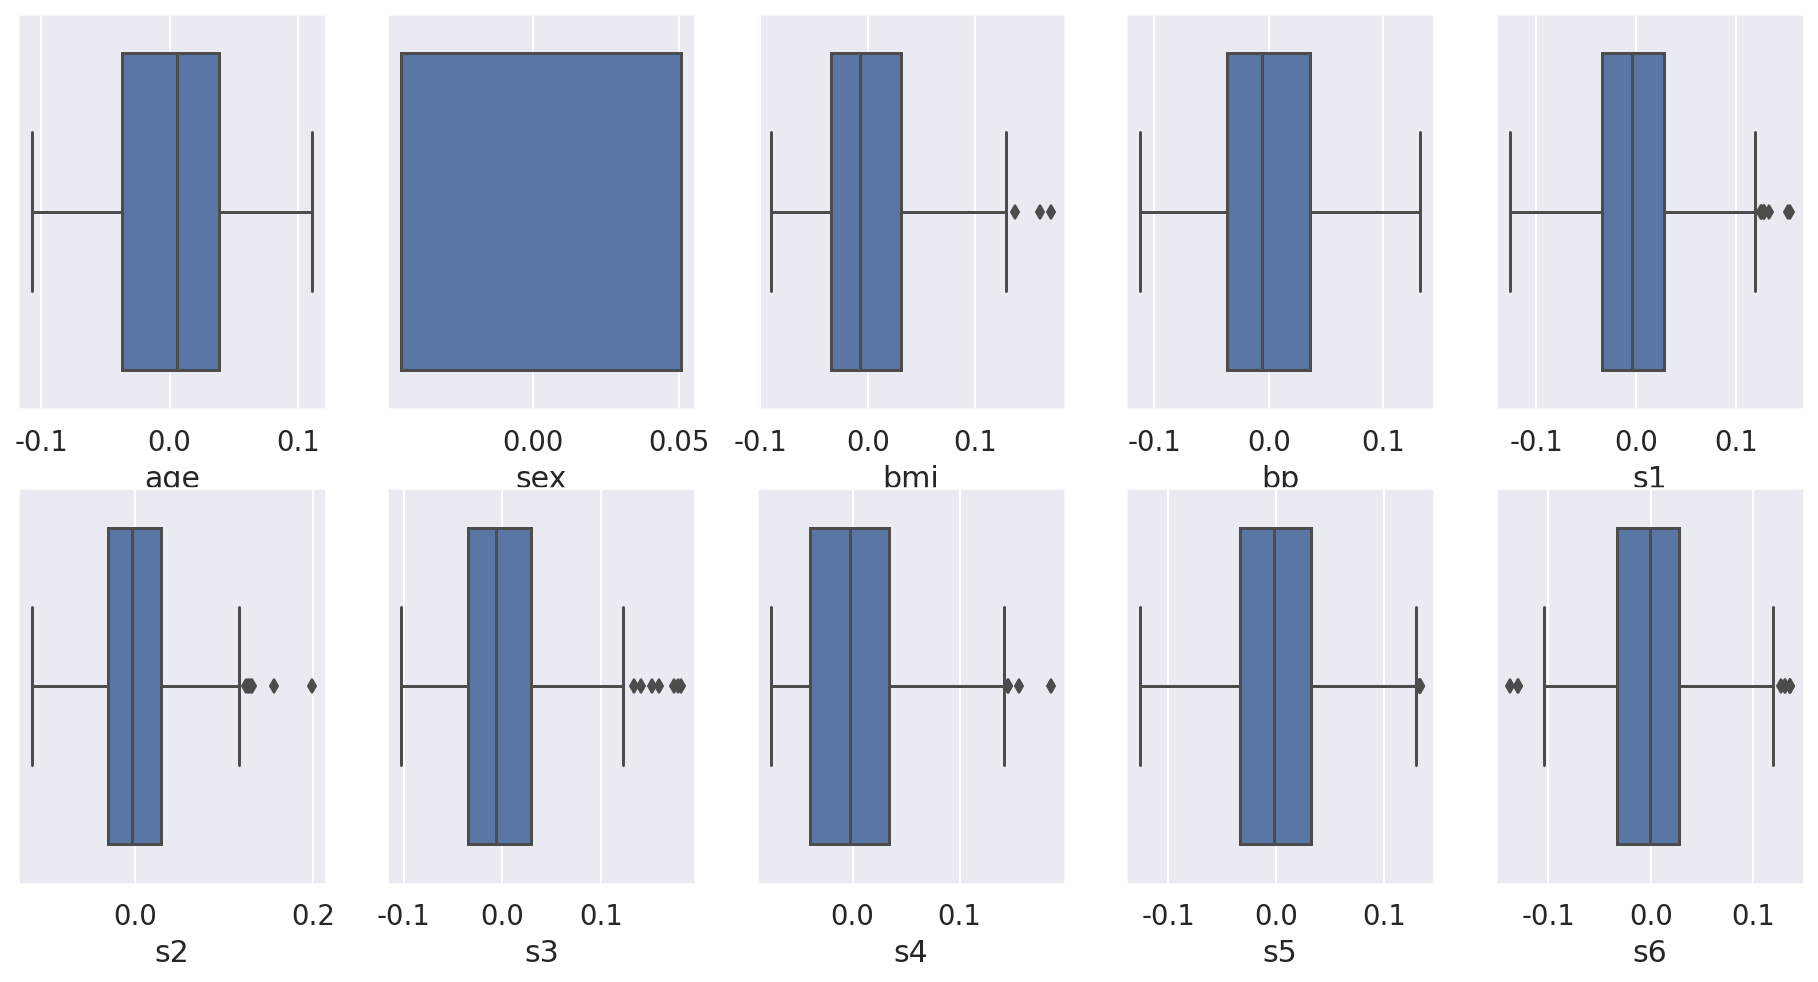

In [139]:
############################## feature scale확인 ##############################
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,8))
for axes, col in zip(axes.flat, diabetes.feature_names):
  sns.boxplot(diabetes_df[col], orient="v",ax=axes)


데이터 분포를 보니 본 데이터는 표준화가 진행된채로 제공되었음을 확실하게 알 수 있다. 

#### **1-2-7. 변수간 상관관계 파악**

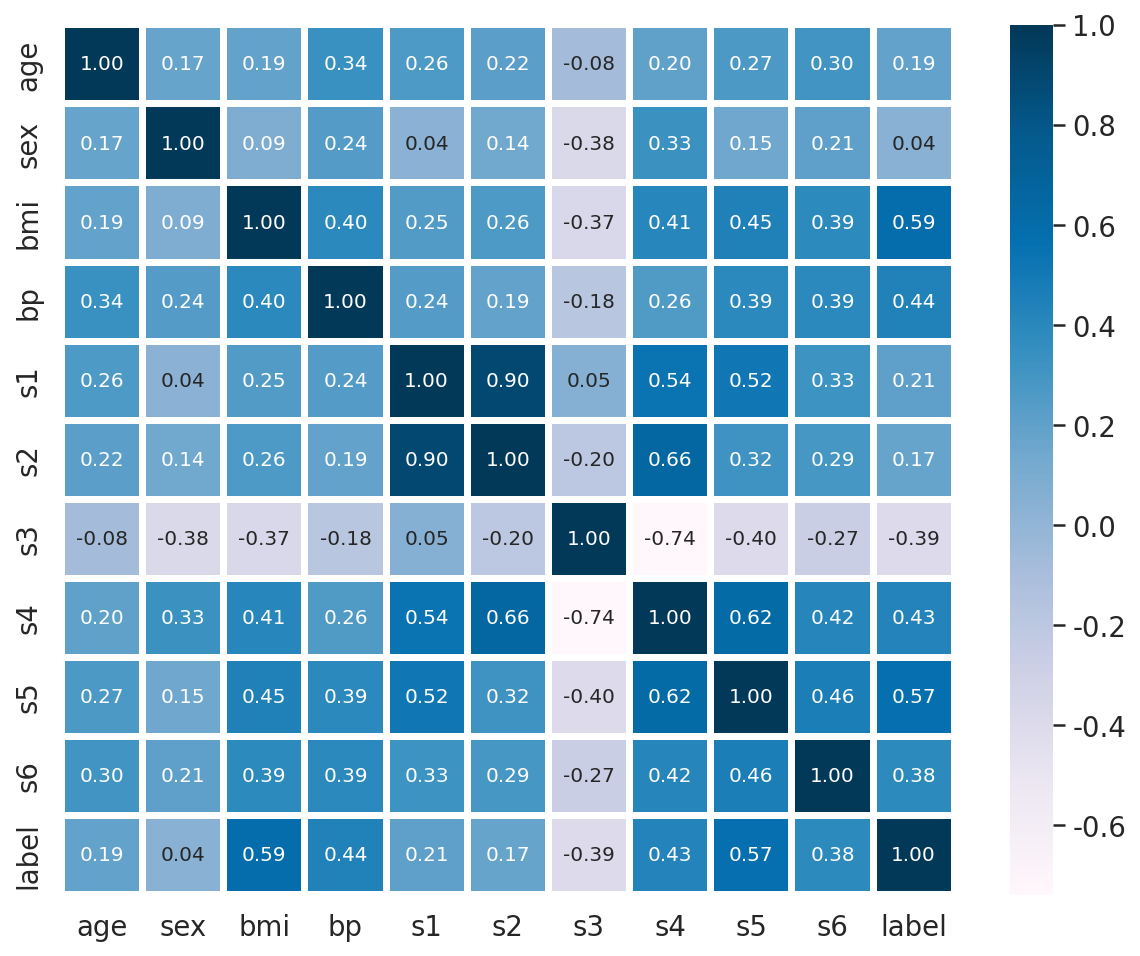

In [140]:
############################## 전체 데이터 상관관계 표시 ##############################
draw_corrmap(diabetes_df)

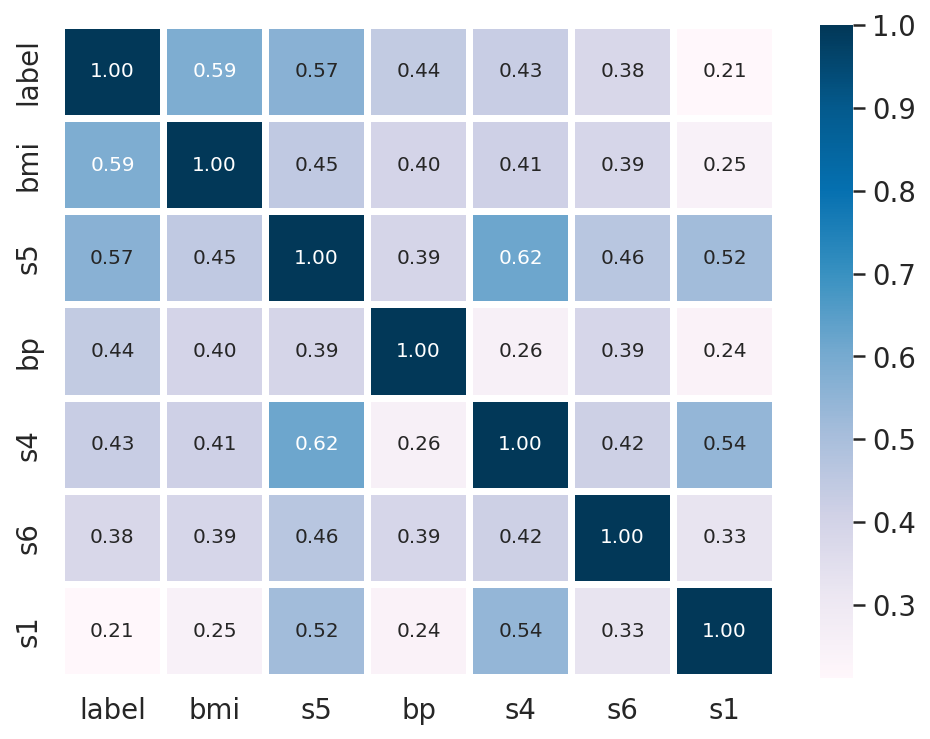

In [141]:
############################## label 기준으로 상관관계 top5 표시 ##############################
draw_top_corrmap(diabetes_df,'label',7)

상관관계를 시각화해보면 bmi,s5 변수가 label과 양의 상관관계를 가지는 것을 볼 수 있다.(0.5 를 기준으로 강력한 상관관계로 판단). 또한 s1,s2 와 같은 혈액검사수치끼리는 서로 양의 상관관계를 가진다. 특히 s4,s5는 대부분의 변수들과 양의 상관관계를 가진다. 이렇게 독립변수끼리 상관관계를 가지는 것을 다중공선성이라고 한다. 일반적으로 회귀분석에서 다중공선성은 결과에 영향을 미칠 수 있기에 처리를 해주는 편이지만 여기서는 생략하도록한다.(모델을 직접 구현해보는것이 목표이므로 전처리는 대부분 생략하기로 !)

### **1-3. 모델 구현**

#### **1-3-1. train/test 나누기**


In [638]:
############################## 학습데이터 나누기 & 교차검증 ##############################

X = np.array(df_X)
y = np.array(df_y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=22)


#### **1-3-2. 가중치 w와 편향 b 준비하기**

In [639]:

import copy

col_cnt = diabetes_df.shape[1]-1
W_origin = np.random.rand(col_cnt)
b_origin = np.random.rand()

W = copy.deepcopy(W_origin)
b = copy.deepcopy(b_origin)




print("\n##############################  Weight ##############################\n")
print(W)
print("\n############################## Bias ##############################\n")
print(b)


##############################  Weight ##############################

[0.60742279 0.46331373 0.12427489 0.29615862 0.11925023 0.07690218
 0.39952048 0.30185467 0.60709336 0.35265697]

############################## Bias ##############################

0.5490232197430505


#### **1-3-3. 모델함수 구현**

In [640]:
def model(X, W, b):
    predictions = 0
    for i in range(col_cnt):
        predictions += X[:, i] * W[i]
    predictions += b
    return predictions

#### **1-3-4. 손실함수 loss정의**

In [641]:
############################### 손실함수를 MSE 함수로 정의 ############################## 
def MSE(a, b):
    mse = ((a - b) ** 2).mean()
    return mse

############################### 손실함수 loss 정의 ############################## 
def loss(X, W, b, y):
    predictions = model(X, W, b)
    L = MSE(predictions, y)
    return L


#### **1-3-5. 기울기구하는 gradient 함수 구현**

In [642]:
############################### 손실함수에 대한 미분 ############################## 

def gradient(X, W, b, y):
    N = len(W)
    y_pred = model(X, W, b)
    dW = 1/N * 2 * X.T.dot(y_pred - y)
    db = 2 * (y_pred - y).mean()
    return dW, db

In [643]:
dW, db = gradient(X, W, b, y)
print("  *dW:", dW)
print(". *db:", db)

  *dW: [ -60.60453103  -13.78715796 -189.72088933 -142.73096585  -68.43540209
  -56.17953199  127.73091847 -139.16663314 -182.96972559 -123.61332891]
. *db: -303.1689218863058


#### **1-3-6. 하이퍼파라미터 학습률 설정**

##### 학습률:  0.1  #####

Iteration 100 : Loss 3078.8225
Iteration 200 : Loss 2955.9706
Iteration 300 : Loss 2940.8290
Iteration 400 : Loss 2937.6044
Iteration 500 : Loss 2936.1325
Iteration 600 : Loss 2935.0833
Iteration 700 : Loss 2934.2240
Iteration 800 : Loss 2933.4931
Iteration 900 : Loss 2932.8634
##### 평균mse값:  2932.322616796269  #####



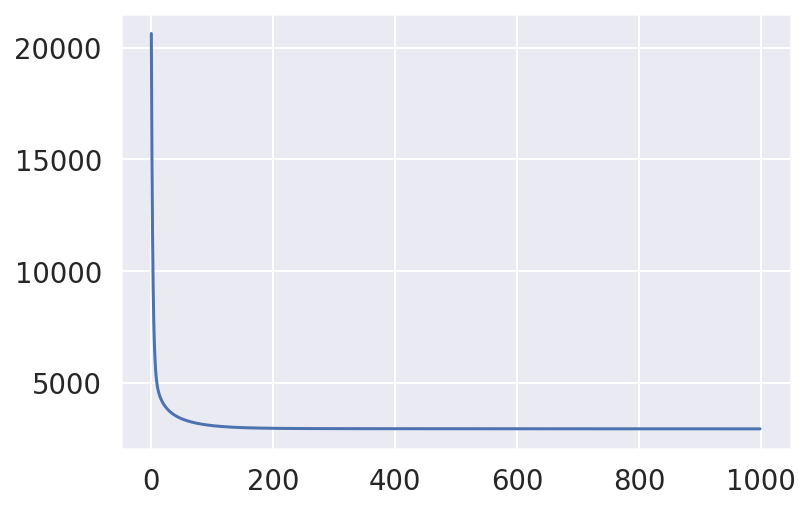

##### 학습률:  0.01  #####

Iteration 100 : Loss 5152.9086
Iteration 200 : Loss 4108.1216
Iteration 300 : Loss 3749.9922
Iteration 400 : Loss 3537.2682
Iteration 500 : Loss 3395.6549
Iteration 600 : Loss 3294.5180
Iteration 700 : Loss 3218.9847
Iteration 800 : Loss 3161.0549
Iteration 900 : Loss 3115.9390
##### 평균mse값:  3080.7985845276444  #####



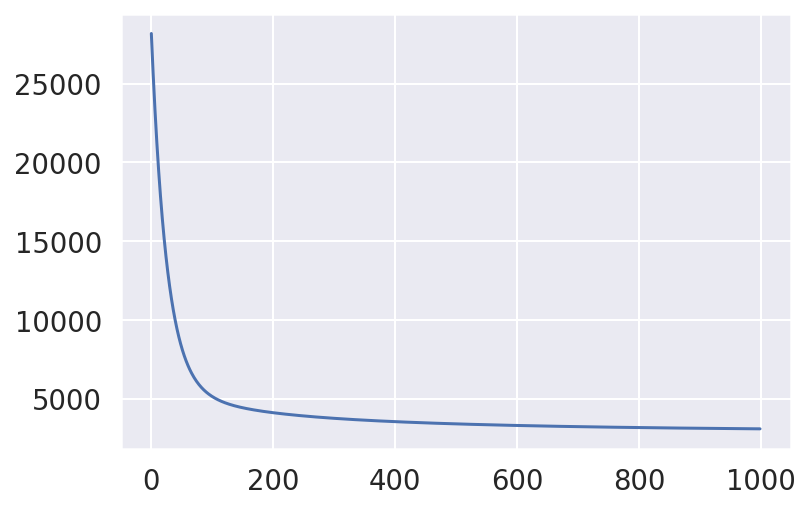

##### 학습률:  0.001  #####

Iteration 100 : Loss 21327.9529
Iteration 200 : Loss 16064.3599
Iteration 300 : Loss 12494.8784
Iteration 400 : Loss 10063.5435
Iteration 500 : Loss 8397.6045
Iteration 600 : Loss 7247.0864
Iteration 700 : Loss 6444.2938
Iteration 800 : Loss 5876.6770
Iteration 900 : Loss 5468.6502
##### 평균mse값:  5171.985831617751  #####



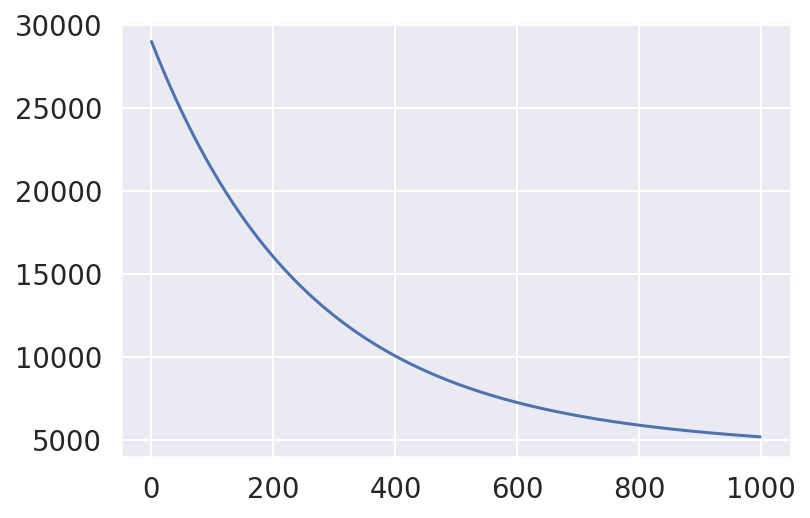

##### 학습률:  0.0001  #####

Iteration 100 : Loss 28192.2913
Iteration 200 : Loss 27305.1441
Iteration 300 : Loss 26452.2073
Iteration 400 : Loss 25632.1434
Iteration 500 : Loss 24843.6675
Iteration 600 : Loss 24085.5451
Iteration 700 : Loss 23356.5901
Iteration 800 : Loss 22655.6628
Iteration 900 : Loss 21981.6681
##### 평균mse값:  21339.910270865093  #####



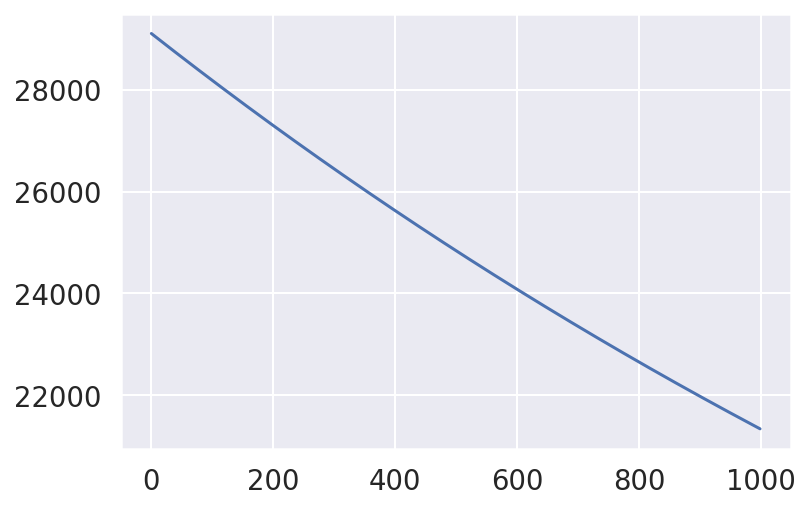

In [644]:
################################################ 직접 학습률 설정 #################################################### 
############################### 반복횟수1000 고정하고 학습률 [0.1,0.01,0.001,0.0001] 적용 ############################## 

lr_list = [0.1,0.01,0.001,0.0001]
max_epoch = 1000

for  lr in lr_list:
  print('======='*10)
  print('##### 학습률: ',lr,' #####\n')
  W = copy.deepcopy(W_origin)
  b = copy.deepcopy(b_origin)
  losses = []
  for i in range(1, max_epoch):
      dW, db = gradient(X_train, W, b, y_train)
      W -= lr * dW
      b -= lr * db
      L = loss(X_train, W, b, y_train)
      losses.append(L)
      if i % 100 == 0:
          print('Iteration %d : Loss %0.4f' % (i, L))
  prediction = model(X_train, W, b)
  mse = loss(X_train, W, b, y_train)
  print('##### 평균mse값: ',mse,' #####\n')
  plt.plot(losses)
  plt.show()

##### 학습률:  0.1  #####

Iteration 100 : Loss 3078.8225
Iteration 200 : Loss 2955.9706
Iteration 300 : Loss 2940.8290
Iteration 400 : Loss 2937.6044
Iteration 500 : Loss 2936.1325
Iteration 600 : Loss 2935.0833
Iteration 700 : Loss 2934.2240
Iteration 800 : Loss 2933.4931
Iteration 900 : Loss 2932.8634
Iteration 1000 : Loss 2932.3175
Iteration 1100 : Loss 2931.8420
Iteration 1200 : Loss 2931.4257
Iteration 1300 : Loss 2931.0595
Iteration 1400 : Loss 2930.7358
Iteration 1500 : Loss 2930.4481
Iteration 1600 : Loss 2930.1909
Iteration 1700 : Loss 2929.9595
Iteration 1800 : Loss 2929.7503
Iteration 1900 : Loss 2929.5598
Iteration 2000 : Loss 2929.3854
Iteration 2100 : Loss 2929.2248
Iteration 2200 : Loss 2929.0759
Iteration 2300 : Loss 2928.9372
Iteration 2400 : Loss 2928.8072
Iteration 2500 : Loss 2928.6849
Iteration 2600 : Loss 2928.5692
Iteration 2700 : Loss 2928.4592
Iteration 2800 : Loss 2928.3543
Iteration 2900 : Loss 2928.2538
Iteration 3000 : Loss 2928.1574
Iteration 3100 : Loss 292

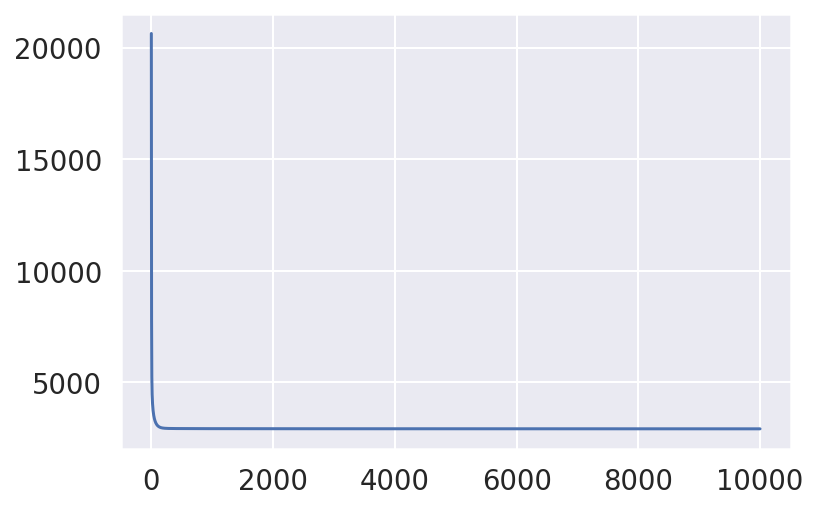

##### 학습률:  0.01  #####

Iteration 100 : Loss 5152.9086
Iteration 200 : Loss 4108.1216
Iteration 300 : Loss 3749.9922
Iteration 400 : Loss 3537.2682
Iteration 500 : Loss 3395.6549
Iteration 600 : Loss 3294.5180
Iteration 700 : Loss 3218.9847
Iteration 800 : Loss 3161.0549
Iteration 900 : Loss 3115.9390
Iteration 1000 : Loss 3080.4840
Iteration 1100 : Loss 3052.4632
Iteration 1200 : Loss 3030.2312
Iteration 1300 : Loss 3012.5379
Iteration 1400 : Loss 2998.4190
Iteration 1500 : Loss 2987.1236
Iteration 1600 : Loss 2978.0638
Iteration 1700 : Loss 2970.7777
Iteration 1800 : Loss 2964.9015
Iteration 1900 : Loss 2960.1479
Iteration 2000 : Loss 2956.2899
Iteration 2100 : Loss 2953.1476
Iteration 2200 : Loss 2950.5783
Iteration 2300 : Loss 2948.4687
Iteration 2400 : Loss 2946.7286
Iteration 2500 : Loss 2945.2862
Iteration 2600 : Loss 2944.0839
Iteration 2700 : Loss 2943.0760
Iteration 2800 : Loss 2942.2258
Iteration 2900 : Loss 2941.5036
Iteration 3000 : Loss 2940.8859
Iteration 3100 : Loss 29

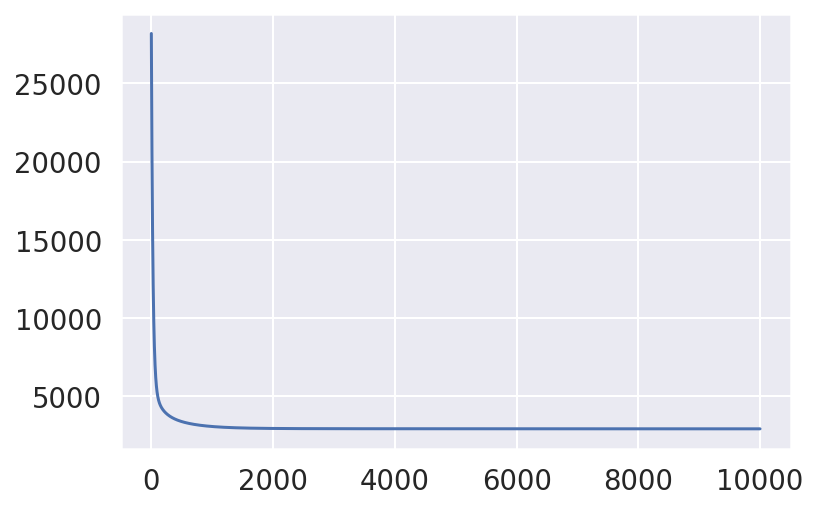

##### 학습률:  0.001  #####

Iteration 100 : Loss 21327.9529
Iteration 200 : Loss 16064.3599
Iteration 300 : Loss 12494.8784
Iteration 400 : Loss 10063.5435
Iteration 500 : Loss 8397.6045
Iteration 600 : Loss 7247.0864
Iteration 700 : Loss 6444.2938
Iteration 800 : Loss 5876.6770
Iteration 900 : Loss 5468.6502
Iteration 1000 : Loss 5169.4089
Iteration 1100 : Loss 4944.7656
Iteration 1200 : Loss 4771.6789
Iteration 1300 : Loss 4634.5866
Iteration 1400 : Loss 4522.9484
Iteration 1500 : Loss 4429.5979
Iteration 1600 : Loss 4349.6382
Iteration 1700 : Loss 4279.7010
Iteration 1800 : Loss 4217.4493
Iteration 1900 : Loss 4161.2438
Iteration 2000 : Loss 4109.9189
Iteration 2100 : Loss 4062.6319
Iteration 2200 : Loss 4018.7615
Iteration 2300 : Loss 3977.8396
Iteration 2400 : Loss 3939.5046
Iteration 2500 : Loss 3903.4707
Iteration 2600 : Loss 3869.5061
Iteration 2700 : Loss 3837.4185
Iteration 2800 : Loss 3807.0450
Iteration 2900 : Loss 3778.2456
Iteration 3000 : Loss 3750.8974
Iteration 3100 : Lo

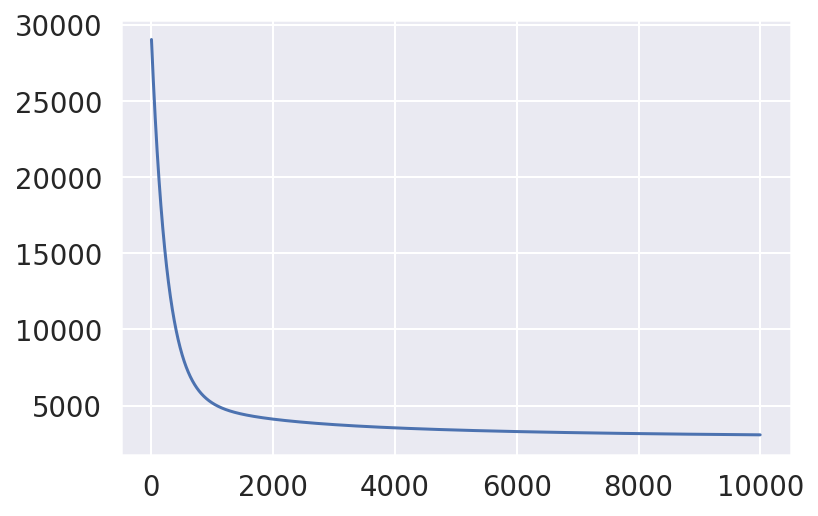

##### 학습률:  0.0001  #####

Iteration 100 : Loss 28192.2913
Iteration 200 : Loss 27305.1441
Iteration 300 : Loss 26452.2073
Iteration 400 : Loss 25632.1434
Iteration 500 : Loss 24843.6675
Iteration 600 : Loss 24085.5451
Iteration 700 : Loss 23356.5901
Iteration 800 : Loss 22655.6628
Iteration 900 : Loss 21981.6681
Iteration 1000 : Loss 21333.5539
Iteration 1100 : Loss 20710.3094
Iteration 1200 : Loss 20110.9633
Iteration 1300 : Loss 19534.5824
Iteration 1400 : Loss 18980.2701
Iteration 1500 : Loss 18447.1648
Iteration 1600 : Loss 17934.4388
Iteration 1700 : Loss 17441.2968
Iteration 1800 : Loss 16966.9747
Iteration 1900 : Loss 16510.7381
Iteration 2000 : Loss 16071.8817
Iteration 2100 : Loss 15649.7276
Iteration 2200 : Loss 15243.6246
Iteration 2300 : Loss 14852.9469
Iteration 2400 : Loss 14477.0932
Iteration 2500 : Loss 14115.4859
Iteration 2600 : Loss 13767.5698
Iteration 2700 : Loss 13432.8117
Iteration 2800 : Loss 13110.6991
Iteration 2900 : Loss 12800.7396
Iteration 3000 : Loss 125

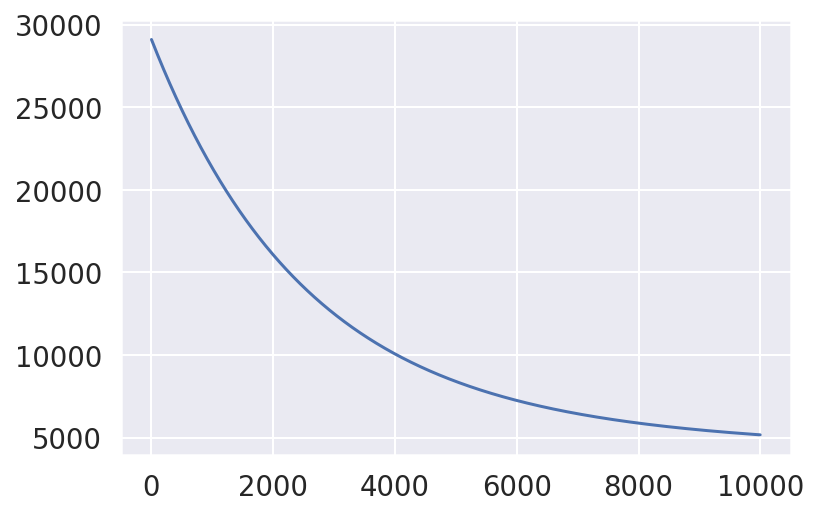

In [645]:
################################################ 직접 학습률 설정 #################################################### 
############################### 반복횟수10000 고정하고 학습률 [0.1,0.01,0.001,0.0001] 적용 ############################## 


lr_list = [0.1,0.01,0.001,0.0001]
max_epoch = 10000

for  lr in lr_list:
  print('======='*10)
  print('##### 학습률: ',lr,' #####\n')
  W = copy.deepcopy(W_origin)
  b = copy.deepcopy(b_origin)
  losses = []
  for i in range(1, max_epoch):
      dW, db = gradient(X_train, W, b, y_train)
      W -= lr * dW
      b -= lr * db
      L = loss(X_train, W, b, y_train)
      losses.append(L)
      if i % 100 == 0:
          print('Iteration %d : Loss %0.4f' % (i, L))
  prediction = model(X_train, W, b)
  mse = loss(X_train, W, b, y_train)
  print('##### 평균mse값: ',mse,' #####\n')
  plt.plot(losses)
  plt.show()

##### 학습률:  0.1  #####

Iteration 1000 : Loss 2932.3175
Iteration 2000 : Loss 2929.3854
Iteration 3000 : Loss 2928.1574
Iteration 4000 : Loss 2927.3413
Iteration 5000 : Loss 2926.6908
Iteration 6000 : Loss 2926.1477
Iteration 7000 : Loss 2925.6897
Iteration 8000 : Loss 2925.3027
Iteration 9000 : Loss 2924.9754
Iteration 10000 : Loss 2924.6987
Iteration 11000 : Loss 2924.4646
Iteration 12000 : Loss 2924.2668
Iteration 13000 : Loss 2924.0994
Iteration 14000 : Loss 2923.9579
Iteration 15000 : Loss 2923.8382
Iteration 16000 : Loss 2923.7371
Iteration 17000 : Loss 2923.6515
Iteration 18000 : Loss 2923.5791
Iteration 19000 : Loss 2923.5179
Iteration 20000 : Loss 2923.4662
Iteration 21000 : Loss 2923.4224
Iteration 22000 : Loss 2923.3854
Iteration 23000 : Loss 2923.3542
Iteration 24000 : Loss 2923.3277
Iteration 25000 : Loss 2923.3053
Iteration 26000 : Loss 2923.2864
Iteration 27000 : Loss 2923.2704
Iteration 28000 : Loss 2923.2569
Iteration 29000 : Loss 2923.2454
##### 평균mse값:  2923.23576985

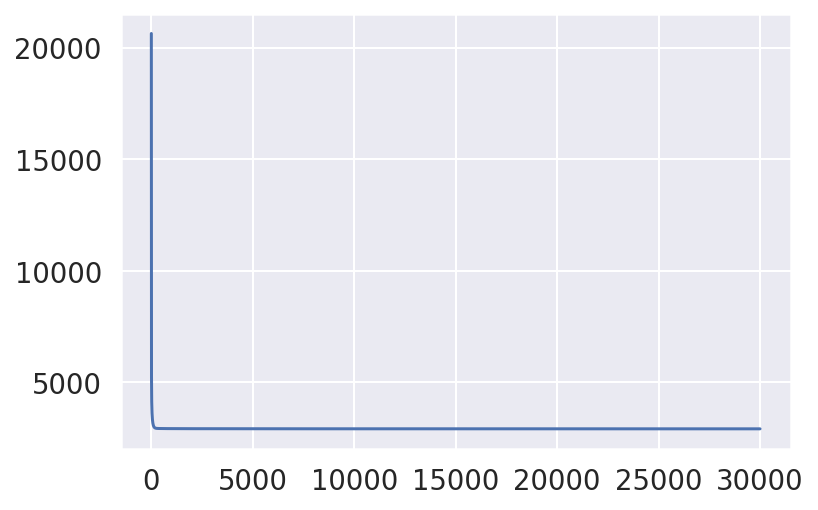

##### 학습률:  0.01  #####

Iteration 1000 : Loss 3080.4840
Iteration 2000 : Loss 2956.2899
Iteration 3000 : Loss 2940.8859
Iteration 4000 : Loss 2937.6167
Iteration 5000 : Loss 2936.1367
Iteration 6000 : Loss 2935.0857
Iteration 7000 : Loss 2934.2260
Iteration 8000 : Loss 2933.4949
Iteration 9000 : Loss 2932.8651
Iteration 10000 : Loss 2932.3191
Iteration 11000 : Loss 2931.8434
Iteration 12000 : Loss 2931.4270
Iteration 13000 : Loss 2931.0608
Iteration 14000 : Loss 2930.7370
Iteration 15000 : Loss 2930.4491
Iteration 16000 : Loss 2930.1918
Iteration 17000 : Loss 2929.9604
Iteration 18000 : Loss 2929.7510
Iteration 19000 : Loss 2929.5605
Iteration 20000 : Loss 2929.3860
Iteration 21000 : Loss 2929.2253
Iteration 22000 : Loss 2929.0764
Iteration 23000 : Loss 2928.9376
Iteration 24000 : Loss 2928.8077
Iteration 25000 : Loss 2928.6853
Iteration 26000 : Loss 2928.5695
Iteration 27000 : Loss 2928.4595
Iteration 28000 : Loss 2928.3546
Iteration 29000 : Loss 2928.2541
##### 평균mse값:  2928.1577004

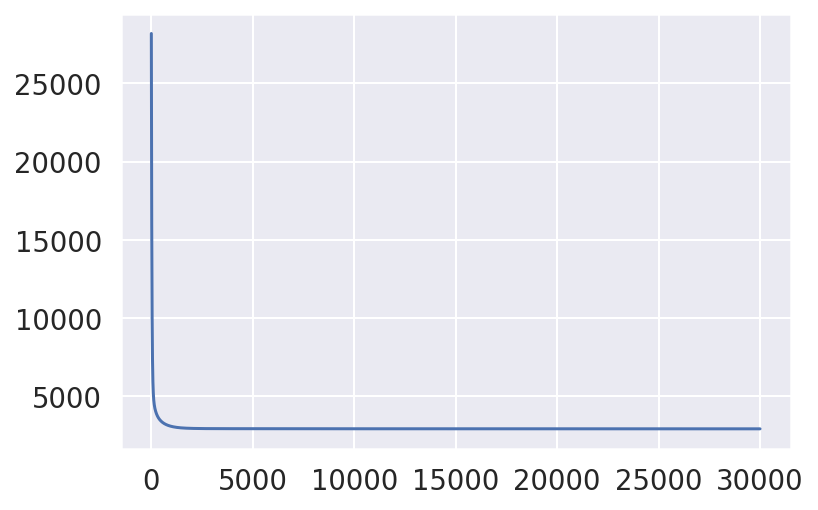

##### 학습률:  0.001  #####

Iteration 1000 : Loss 5169.4089
Iteration 2000 : Loss 4109.9189
Iteration 3000 : Loss 3750.8974
Iteration 4000 : Loss 3537.8833
Iteration 5000 : Loss 3396.0975
Iteration 6000 : Loss 3294.8569
Iteration 7000 : Loss 3219.2583
Iteration 8000 : Loss 3161.2834
Iteration 9000 : Loss 3116.1333
Iteration 10000 : Loss 3080.6503
Iteration 11000 : Loss 3052.6058
Iteration 12000 : Loss 3030.3532
Iteration 13000 : Loss 3012.6420
Iteration 14000 : Loss 2998.5076
Iteration 15000 : Loss 2987.1988
Iteration 16000 : Loss 2978.1274
Iteration 17000 : Loss 2970.8315
Iteration 18000 : Loss 2964.9468
Iteration 19000 : Loss 2960.1860
Iteration 20000 : Loss 2956.3220
Iteration 21000 : Loss 2953.1745
Iteration 22000 : Loss 2950.6010
Iteration 23000 : Loss 2948.4878
Iteration 24000 : Loss 2946.7447
Iteration 25000 : Loss 2945.2996
Iteration 26000 : Loss 2944.0953
Iteration 27000 : Loss 2943.0856
Iteration 28000 : Loss 2942.2338
Iteration 29000 : Loss 2941.5104
##### 평균mse값:  2940.892236

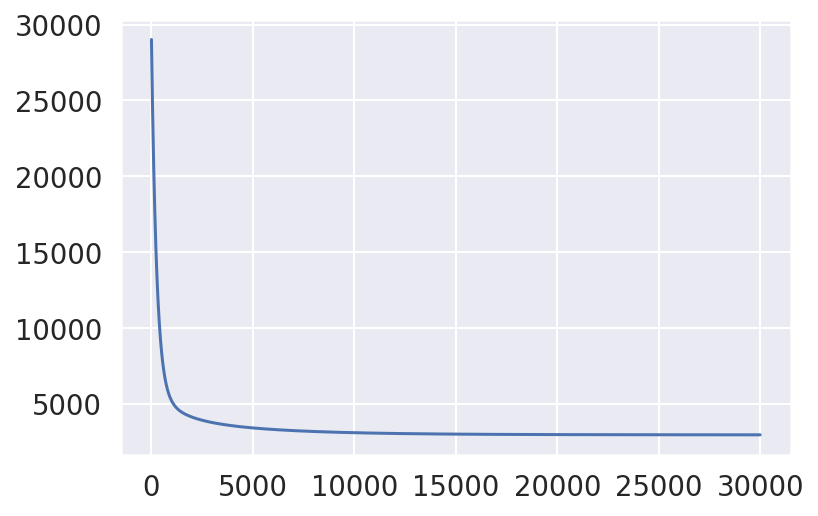

##### 학습률:  0.0001  #####

Iteration 1000 : Loss 21333.5539
Iteration 2000 : Loss 16071.8817
Iteration 3000 : Loss 12502.4601
Iteration 4000 : Loss 10070.3432
Iteration 5000 : Loss 8403.3296
Iteration 6000 : Loss 7251.7224
Iteration 7000 : Loss 6447.9529
Iteration 8000 : Loss 5879.5157
Iteration 9000 : Loss 5470.8279
Iteration 10000 : Loss 5171.0689
Iteration 11000 : Loss 4946.0282
Iteration 12000 : Loss 4772.6410
Iteration 13000 : Loss 4635.3242
Iteration 14000 : Loss 4523.5195
Iteration 15000 : Loss 4430.0463
Iteration 16000 : Loss 4349.9965
Iteration 17000 : Loss 4279.9932
Iteration 18000 : Loss 4217.6929
Iteration 19000 : Loss 4161.4515
Iteration 20000 : Loss 4110.0999
Iteration 21000 : Loss 4062.7929
Iteration 22000 : Loss 4018.9072
Iteration 23000 : Loss 3977.9732
Iteration 24000 : Loss 3939.6287
Iteration 25000 : Loss 3903.5870
Iteration 26000 : Loss 3869.6158
Iteration 27000 : Loss 3837.5225
Iteration 28000 : Loss 3807.1441
Iteration 29000 : Loss 3778.3402
##### 평균mse값:  3751.0

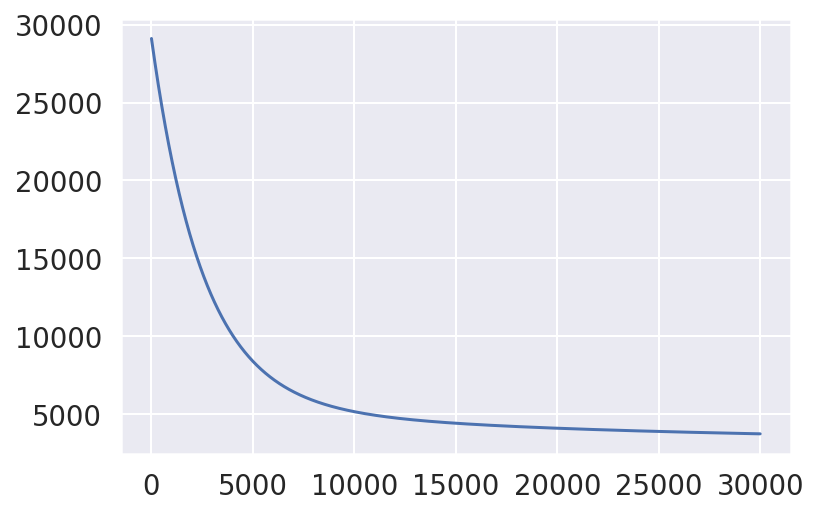

In [646]:
################################################ 직접 학습률 설정 #################################################### 
############################### 반복횟수30000 고정하고 학습률 [0.1,0.01,0.001,0.0001] 적용 ############################## 


lr_list = [0.1,0.01,0.001,0.0001]
max_epoch = 30000

for  lr in lr_list:
  print('======='*10)
  print('##### 학습률: ',lr,' #####\n')
  W = copy.deepcopy(W_origin)
  b = copy.deepcopy(b_origin)
  losses = []
  for i in range(1, max_epoch):
      dW, db = gradient(X_train, W, b, y_train)
      W -= lr * dW
      b -= lr * db
      L = loss(X_train, W, b, y_train)
      losses.append(L)
      if i % 1000 == 0:
          print('Iteration %d : Loss %0.4f' % (i, L))
  prediction = model(X_train, W, b)
  mse = loss(X_train, W, b, y_train)
  print('##### 평균mse값: ',mse,' #####\n')
  plt.plot(losses)
  plt.show()

##### 학습률:  0.1  #####

Iteration 1000 : Loss 2932.3175
Iteration 2000 : Loss 2929.3854
Iteration 3000 : Loss 2928.1574
Iteration 4000 : Loss 2927.3413
Iteration 5000 : Loss 2926.6908
Iteration 6000 : Loss 2926.1477
Iteration 7000 : Loss 2925.6897
Iteration 8000 : Loss 2925.3027
Iteration 9000 : Loss 2924.9754
Iteration 10000 : Loss 2924.6987
Iteration 11000 : Loss 2924.4646
Iteration 12000 : Loss 2924.2668
Iteration 13000 : Loss 2924.0994
Iteration 14000 : Loss 2923.9579
Iteration 15000 : Loss 2923.8382
Iteration 16000 : Loss 2923.7371
Iteration 17000 : Loss 2923.6515
Iteration 18000 : Loss 2923.5791
Iteration 19000 : Loss 2923.5179
Iteration 20000 : Loss 2923.4662
Iteration 21000 : Loss 2923.4224
Iteration 22000 : Loss 2923.3854
Iteration 23000 : Loss 2923.3542
Iteration 24000 : Loss 2923.3277
Iteration 25000 : Loss 2923.3053
Iteration 26000 : Loss 2923.2864
Iteration 27000 : Loss 2923.2704
Iteration 28000 : Loss 2923.2569
Iteration 29000 : Loss 2923.2454
Iteration 30000 : Loss 2923.

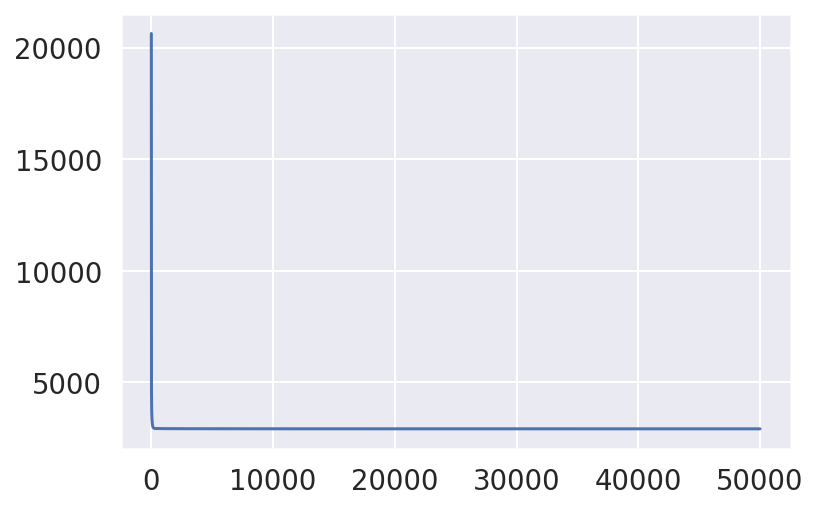

##### 학습률:  0.01  #####

Iteration 1000 : Loss 3080.4840
Iteration 2000 : Loss 2956.2899
Iteration 3000 : Loss 2940.8859
Iteration 4000 : Loss 2937.6167
Iteration 5000 : Loss 2936.1367
Iteration 6000 : Loss 2935.0857
Iteration 7000 : Loss 2934.2260
Iteration 8000 : Loss 2933.4949
Iteration 9000 : Loss 2932.8651
Iteration 10000 : Loss 2932.3191
Iteration 11000 : Loss 2931.8434
Iteration 12000 : Loss 2931.4270
Iteration 13000 : Loss 2931.0608
Iteration 14000 : Loss 2930.7370
Iteration 15000 : Loss 2930.4491
Iteration 16000 : Loss 2930.1918
Iteration 17000 : Loss 2929.9604
Iteration 18000 : Loss 2929.7510
Iteration 19000 : Loss 2929.5605
Iteration 20000 : Loss 2929.3860
Iteration 21000 : Loss 2929.2253
Iteration 22000 : Loss 2929.0764
Iteration 23000 : Loss 2928.9376
Iteration 24000 : Loss 2928.8077
Iteration 25000 : Loss 2928.6853
Iteration 26000 : Loss 2928.5695
Iteration 27000 : Loss 2928.4595
Iteration 28000 : Loss 2928.3546
Iteration 29000 : Loss 2928.2541
Iteration 30000 : Loss 2928

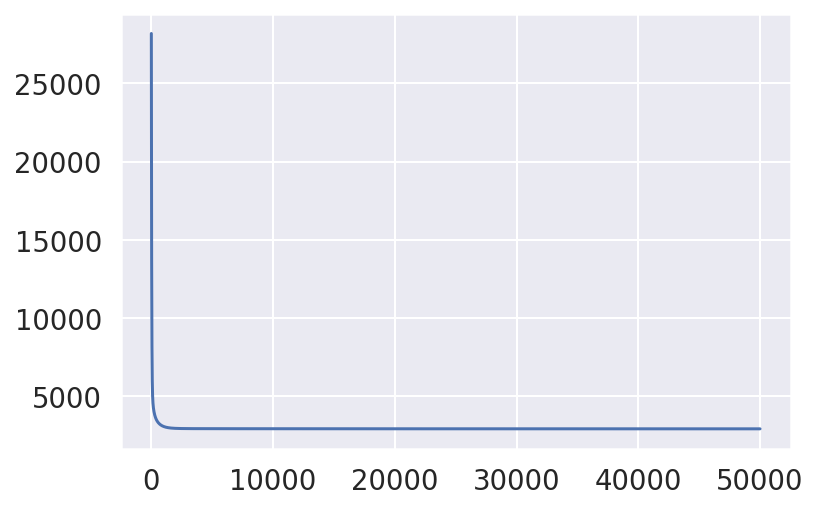

##### 학습률:  0.001  #####

Iteration 1000 : Loss 5169.4089
Iteration 2000 : Loss 4109.9189
Iteration 3000 : Loss 3750.8974
Iteration 4000 : Loss 3537.8833
Iteration 5000 : Loss 3396.0975
Iteration 6000 : Loss 3294.8569
Iteration 7000 : Loss 3219.2583
Iteration 8000 : Loss 3161.2834
Iteration 9000 : Loss 3116.1333
Iteration 10000 : Loss 3080.6503
Iteration 11000 : Loss 3052.6058
Iteration 12000 : Loss 3030.3532
Iteration 13000 : Loss 3012.6420
Iteration 14000 : Loss 2998.5076
Iteration 15000 : Loss 2987.1988
Iteration 16000 : Loss 2978.1274
Iteration 17000 : Loss 2970.8315
Iteration 18000 : Loss 2964.9468
Iteration 19000 : Loss 2960.1860
Iteration 20000 : Loss 2956.3220
Iteration 21000 : Loss 2953.1745
Iteration 22000 : Loss 2950.6010
Iteration 23000 : Loss 2948.4878
Iteration 24000 : Loss 2946.7447
Iteration 25000 : Loss 2945.2996
Iteration 26000 : Loss 2944.0953
Iteration 27000 : Loss 2943.0856
Iteration 28000 : Loss 2942.2338
Iteration 29000 : Loss 2941.5104
Iteration 30000 : Loss 294

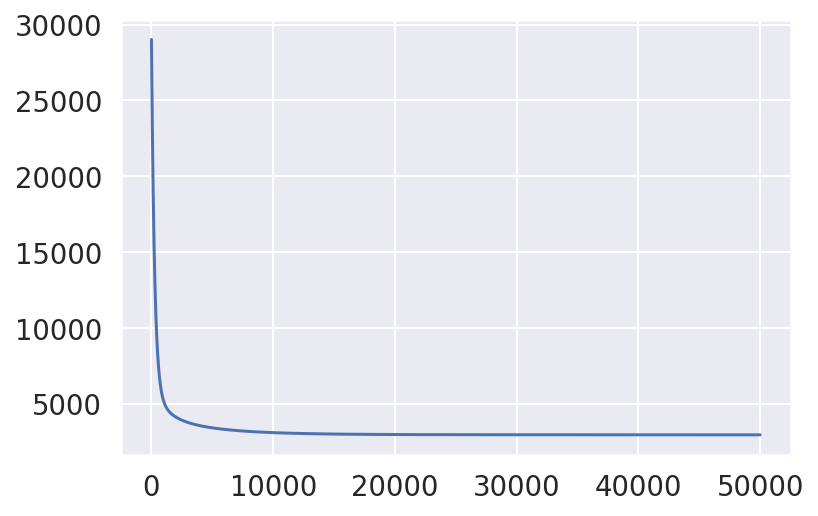

##### 학습률:  0.0001  #####

Iteration 1000 : Loss 21333.5539
Iteration 2000 : Loss 16071.8817
Iteration 3000 : Loss 12502.4601
Iteration 4000 : Loss 10070.3432
Iteration 5000 : Loss 8403.3296
Iteration 6000 : Loss 7251.7224
Iteration 7000 : Loss 6447.9529
Iteration 8000 : Loss 5879.5157
Iteration 9000 : Loss 5470.8279
Iteration 10000 : Loss 5171.0689
Iteration 11000 : Loss 4946.0282
Iteration 12000 : Loss 4772.6410
Iteration 13000 : Loss 4635.3242
Iteration 14000 : Loss 4523.5195
Iteration 15000 : Loss 4430.0463
Iteration 16000 : Loss 4349.9965
Iteration 17000 : Loss 4279.9932
Iteration 18000 : Loss 4217.6929
Iteration 19000 : Loss 4161.4515
Iteration 20000 : Loss 4110.0999
Iteration 21000 : Loss 4062.7929
Iteration 22000 : Loss 4018.9072
Iteration 23000 : Loss 3977.9732
Iteration 24000 : Loss 3939.6287
Iteration 25000 : Loss 3903.5870
Iteration 26000 : Loss 3869.6158
Iteration 27000 : Loss 3837.5225
Iteration 28000 : Loss 3807.1441
Iteration 29000 : Loss 3778.3402
Iteration 30000 : Los

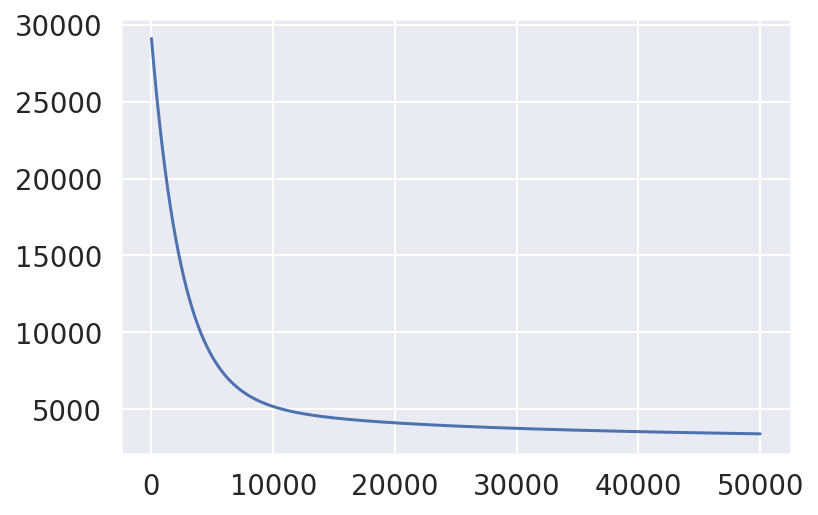

In [647]:
################################################ 직접 학습률 설정 #################################################### 
############################### 반복횟수50000 고정하고 학습률 [0.1,0.01,0.001,0.0001] 적용 ############################## 


lr_list = [0.1,0.01,0.001,0.0001]
max_epoch = 50000

for  lr in lr_list:
  print('======='*10)
  print('##### 학습률: ',lr,' #####\n')
  W = copy.deepcopy(W_origin)
  b = copy.deepcopy(b_origin)
  losses = []
  for i in range(1, max_epoch):
      dW, db = gradient(X_train, W, b, y_train)
      W -= lr * dW
      b -= lr * db
      L = loss(X_train, W, b, y_train)
      losses.append(L)
      if i % 1000 == 0:
          print('Iteration %d : Loss %0.4f' % (i, L))
  prediction = model(X_train, W, b)
  mse = loss(X_train, W, b, y_train)
  print('##### 평균mse값: ',mse,' #####\n')
  plt.plot(losses)
  plt.show()


<div>
그래프와 에포크가 고정되어있을때 초기 학습률을 높게 셋팅할수록 낮은 loss값을 얻었다. 학습률을 너무 낮게 설정해도 에포크가 고정되어있으면 제대로 loss를 줄이지못하고 학습을 끝낼수있다는것을 알 수 있다.<br>
또한 같은 학습률이여도 학습횟수가 높은것이 더 빨리 loss 줄일수있었다. 하지만 그렇다고 학습횟수가 높은것만이 좋다고는 볼 수 없는게 특정 횟수를 기준으로 loss값이 비슷한 값으로 수렴하는 상황도 보였기에 적절한 학습횟수를 지정하는것이 중요하다. 직접 학습률과 학습횟수를 지정했을 때는 학습률이 0.1 이고 학습횟수가 30000인것이 가장 mse 가 낮았다.
<br>학습률을 잘 설정하는것이 중요한데, 매우 크게 설정할 경우에는 오버슈팅이 될 가능성이 있고 반대로 너무 작게 설정을 하면 굉장한 시간이 소요되며 가중치 갱신이 충분히 진행되지않은 채 학습이 끝날 수 있다. 
<br>
위에서 진행한 적절한 학습률 선택을 위한 학습률 스케줄링을 사용해보도록하겠다. 다양한 스케쥴링방법이 있지만 튜닝이 쉽고  Local minimum 에 빨리 수렴하는 <strong>지수기반 스케줄링</strong>이 선호된다.
해당 프로젝트에서도 지수기반 스케줄링을 활용해보았다. 아래는 지수기반 스케쥴링의 공식이다.
</div>
<img src='./src/img/Exponential Scheduling.png'></img>
<div>
t: 반복 횟수 / n_0: 초기 학습률 / s: 스텝 횟수</br>
$t=s$ 일땐 $(0.1)^1$, $t=2s$ 일땐 $(0.1)^2$, 이런 식으로 t가 늘어날 때마다 학습률이 감소되는 스케줄링 방식이다. 
s의 정확한 값은 그다지 중요하지 않고 큰 차이를 만드는 것은 학습률 자체에 있다. 
</div>

##### 초기 학습률:  0.1  #####

  **[Iteration 100] Loss:  3086.9536, LEARNING_RATE:  0.09506
  **[Iteration 200] Loss:  2959.7269, LEARNING_RATE:  0.09036
  **[Iteration 300] Loss:  2942.2903, LEARNING_RATE:  0.08589
  **[Iteration 400] Loss:  2938.4542, LEARNING_RATE:  0.08165
  **[Iteration 500] Loss:  2936.9075, LEARNING_RATE:  0.07761
  **[Iteration 600] Loss:  2935.9334, LEARNING_RATE:  0.07377
  **[Iteration 700] Loss:  2935.1868, LEARNING_RATE:  0.07013
  **[Iteration 800] Loss:  2934.5718, LEARNING_RATE:  0.06666
  **[Iteration 900] Loss:  2934.0502, LEARNING_RATE:  0.06336
##### 평균mse값:  2933.6056245186946  #####





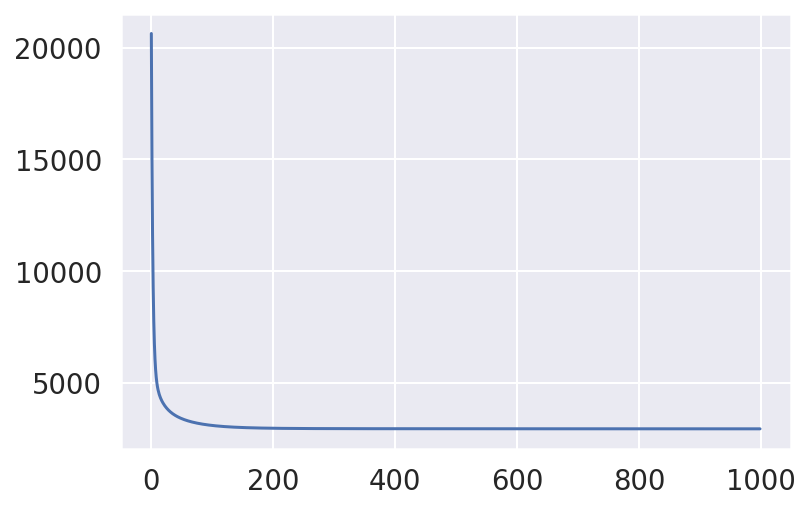



##### 초기 학습률:  0.01  #####

  **[Iteration 100] Loss:  5219.3977, LEARNING_RATE:  0.00951
  **[Iteration 200] Loss:  4158.5116, LEARNING_RATE:  0.00904
  **[Iteration 300] Loss:  3811.3819, LEARNING_RATE:  0.00859
  **[Iteration 400] Loss:  3607.3519, LEARNING_RATE:  0.00816
  **[Iteration 500] Loss:  3472.1393, LEARNING_RATE:  0.00776
  **[Iteration 600] Loss:  3375.9754, LEARNING_RATE:  0.00738
  **[Iteration 700] Loss:  3304.1466, LEARNING_RATE:  0.00701
  **[Iteration 800] Loss:  3248.6377, LEARNING_RATE:  0.00667
  **[Iteration 900] Loss:  3204.6959, LEARNING_RATE:  0.00634
##### 평균mse값:  3169.6088135374016  #####





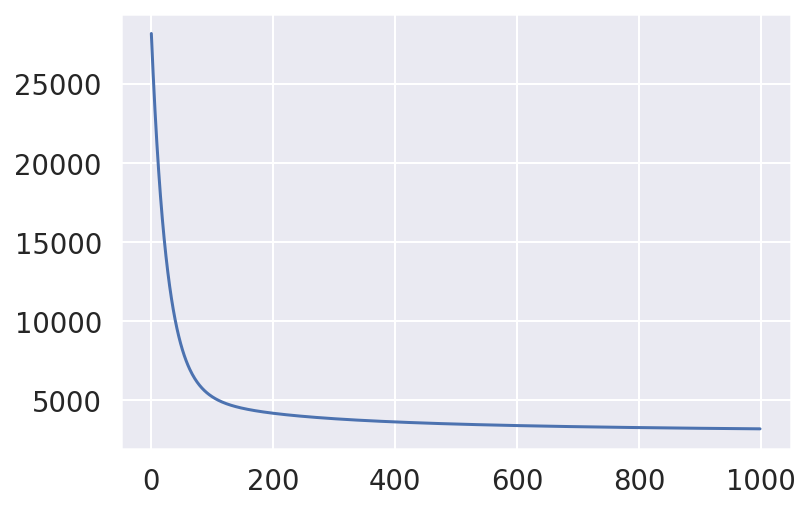



##### 초기 학습률:  0.001  #####

  **[Iteration 100] Loss:  21488.9532, LEARNING_RATE:  0.00095
  **[Iteration 200] Loss:  16497.1320, LEARNING_RATE:  0.00090
  **[Iteration 300] Loss:  13159.7388, LEARNING_RATE:  0.00086
  **[Iteration 400] Loss:  10881.9663, LEARNING_RATE:  0.00082
  **[Iteration 500] Loss:  9295.7824, LEARNING_RATE:  0.00078
  **[Iteration 600] Loss:  8169.2711, LEARNING_RATE:  0.00074
  **[Iteration 700] Loss:  7353.7079, LEARNING_RATE:  0.00070
  **[Iteration 800] Loss:  6752.1004, LEARNING_RATE:  0.00067
  **[Iteration 900] Loss:  6300.1628, LEARNING_RATE:  0.00063
##### 평균mse값:  5957.6535909512295  #####





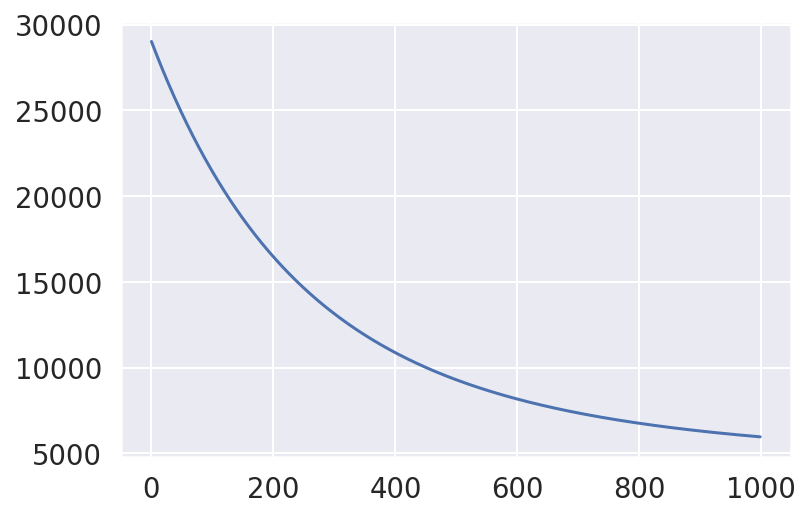



##### 초기 학습률:  0.0001  #####

  **[Iteration 100] Loss:  28215.0780, LEARNING_RATE:  0.00010
  **[Iteration 200] Loss:  27391.0223, LEARNING_RATE:  0.00009
  **[Iteration 300] Loss:  26635.0601, LEARNING_RATE:  0.00009
  **[Iteration 400] Loss:  25940.3333, LEARNING_RATE:  0.00008
  **[Iteration 500] Loss:  25300.8044, LEARNING_RATE:  0.00008
  **[Iteration 600] Loss:  24711.1446, LEARNING_RATE:  0.00007
  **[Iteration 700] Loss:  24166.6379, LEARNING_RATE:  0.00007
  **[Iteration 800] Loss:  23663.0996, LEARNING_RATE:  0.00007
  **[Iteration 900] Loss:  23196.8081, LEARNING_RATE:  0.00006
##### 평균mse값:  22768.61058725848  #####





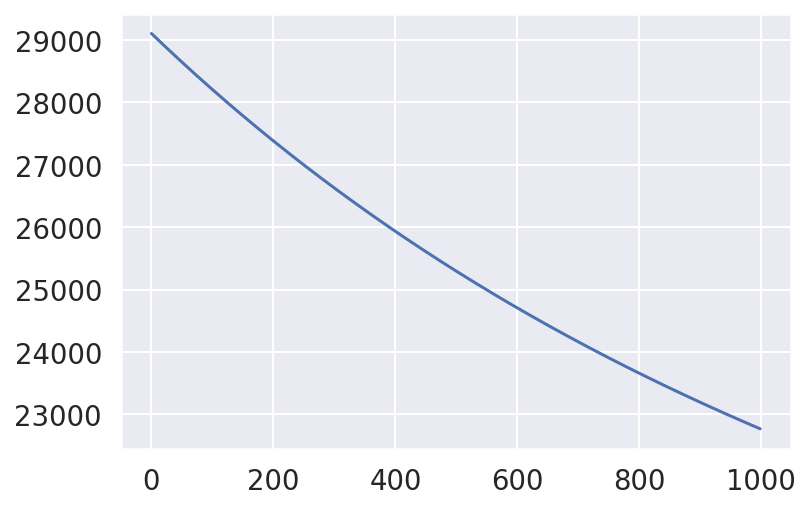

In [648]:

################################################ 지수기반 스케줄러로 학습률 설정 ########################################
############################### 반복횟수1000 고정하고 학습률 [0.1,0.01,0.001,0.0001] 적용 ############################## 

# 지수기반 스케줄러
def exponential_decay(init_lr, step):
  def exponential_decay_fn(epoch):
    return init_lr * 0.1 ** (epoch / step)
  return exponential_decay_fn

 
init_lr_list = [0.1,0.01,0.001,0.0001]
max_epoch = 1000
step = random.randint(max_epoch/2,max_epoch*5) # 100 epochs 값이 필요할때 s는 50~500 사이 권장 # 1000 epochs 값이 필요할때 500~5000 사이
  
for lr in init_lr_list:
  print('======='*10)
  print('##### 초기 학습률: ',lr,' #####\n')
  W = copy.deepcopy(W_origin)
  b = copy.deepcopy(b_origin)
  losses = []
  for epoch in range(1, max_epoch):
        dW, db = gradient(X_train, W, b, y_train)
        LEARNING_RATE = exponential_decay(lr, step)(epoch)
        W -= LEARNING_RATE * dW
        b -= LEARNING_RATE * db
        L = loss(X_train, W, b, y_train)
        losses.append(L)
        if epoch % 100 == 0:
          print(f'  **[Iteration {epoch}] Loss: {L: 0.4f}, LEARNING_RATE: {LEARNING_RATE: 0.5f}' )
  prediction = model(X_train, W, b)
  mse = loss(X_train, W, b, y_train)
  print('##### 평균mse값: ',mse,' #####\n')

  print('\n')
  plt.plot(losses)
  plt.show()
  print('\n')
  

##### 초기 학습률:  0.1  #####

  **[Iteration 100] Loss:  3079.5852, LEARNING_RATE:  0.09952
  **[Iteration 200] Loss:  2956.3051, LEARNING_RATE:  0.09904
  **[Iteration 300] Loss:  2940.9530, LEARNING_RATE:  0.09857
  **[Iteration 400] Loss:  2937.6787, LEARNING_RATE:  0.09809
  **[Iteration 500] Loss:  2936.2044, LEARNING_RATE:  0.09762
  **[Iteration 600] Loss:  2935.1646, LEARNING_RATE:  0.09715
  **[Iteration 700] Loss:  2934.3170, LEARNING_RATE:  0.09669
  **[Iteration 800] Loss:  2933.5973, LEARNING_RATE:  0.09622
  **[Iteration 900] Loss:  2932.9776, LEARNING_RATE:  0.09576
  **[Iteration 1000] Loss:  2932.4401, LEARNING_RATE:  0.09530
  **[Iteration 1100] Loss:  2931.9716, LEARNING_RATE:  0.09485
  **[Iteration 1200] Loss:  2931.5612, LEARNING_RATE:  0.09439
  **[Iteration 1300] Loss:  2931.2000, LEARNING_RATE:  0.09394
  **[Iteration 1400] Loss:  2930.8804, LEARNING_RATE:  0.09349
  **[Iteration 1500] Loss:  2930.5962, LEARNING_RATE:  0.09304
  **[Iteration 1600] Loss:  2930.3420

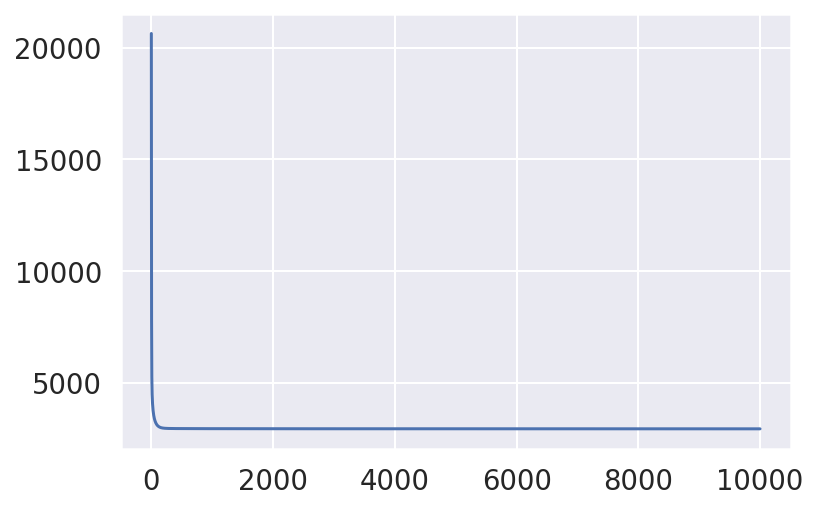



##### 초기 학습률:  0.01  #####

  **[Iteration 100] Loss:  5159.1062, LEARNING_RATE:  0.00995
  **[Iteration 200] Loss:  4112.8692, LEARNING_RATE:  0.00990
  **[Iteration 300] Loss:  3755.7858, LEARNING_RATE:  0.00986
  **[Iteration 400] Loss:  3543.8422, LEARNING_RATE:  0.00981
  **[Iteration 500] Loss:  3402.7865, LEARNING_RATE:  0.00976
  **[Iteration 600] Loss:  3302.0577, LEARNING_RATE:  0.00972
  **[Iteration 700] Loss:  3226.7831, LEARNING_RATE:  0.00967
  **[Iteration 800] Loss:  3168.9544, LEARNING_RATE:  0.00962
  **[Iteration 900] Loss:  3123.7869, LEARNING_RATE:  0.00958
  **[Iteration 1000] Loss:  3088.1467, LEARNING_RATE:  0.00953
  **[Iteration 1100] Loss:  3059.8339, LEARNING_RATE:  0.00948
  **[Iteration 1200] Loss:  3037.2313, LEARNING_RATE:  0.00944
  **[Iteration 1300] Loss:  3019.1155, LEARNING_RATE:  0.00939
  **[Iteration 1400] Loss:  3004.5450, LEARNING_RATE:  0.00935
  **[Iteration 1500] Loss:  2992.7874, LEARNING_RATE:  0.00930
  **[Iteration 1600] Loss:  2983.2

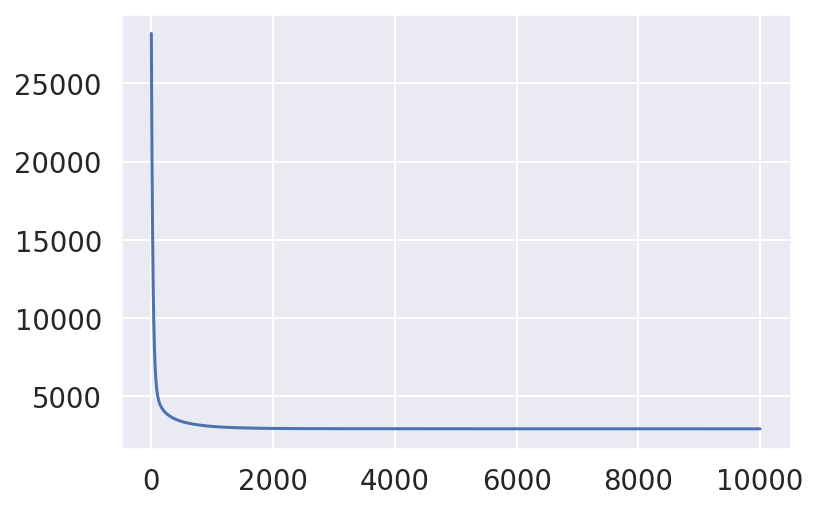



##### 초기 학습률:  0.001  #####

  **[Iteration 100] Loss:  21343.3990, LEARNING_RATE:  0.00100
  **[Iteration 200] Loss:  16105.9721, LEARNING_RATE:  0.00099
  **[Iteration 300] Loss:  12558.4438, LEARNING_RATE:  0.00099
  **[Iteration 400] Loss:  10140.7881, LEARNING_RATE:  0.00098
  **[Iteration 500] Loss:  8480.7629, LEARNING_RATE:  0.00098
  **[Iteration 600] Loss:  7330.4075, LEARNING_RATE:  0.00097
  **[Iteration 700] Loss:  6524.1766, LEARNING_RATE:  0.00097
  **[Iteration 800] Loss:  5951.2871, LEARNING_RATE:  0.00096
  **[Iteration 900] Loss:  5537.4161, LEARNING_RATE:  0.00096
  **[Iteration 1000] Loss:  5232.5659, LEARNING_RATE:  0.00095
  **[Iteration 1100] Loss:  5003.0015, LEARNING_RATE:  0.00095
  **[Iteration 1200] Loss:  4825.8848, LEARNING_RATE:  0.00094
  **[Iteration 1300] Loss:  4685.6954, LEARNING_RATE:  0.00094
  **[Iteration 1400] Loss:  4571.8390, LEARNING_RATE:  0.00093
  **[Iteration 1500] Loss:  4477.0457, LEARNING_RATE:  0.00093
  **[Iteration 1600] Loss:  4

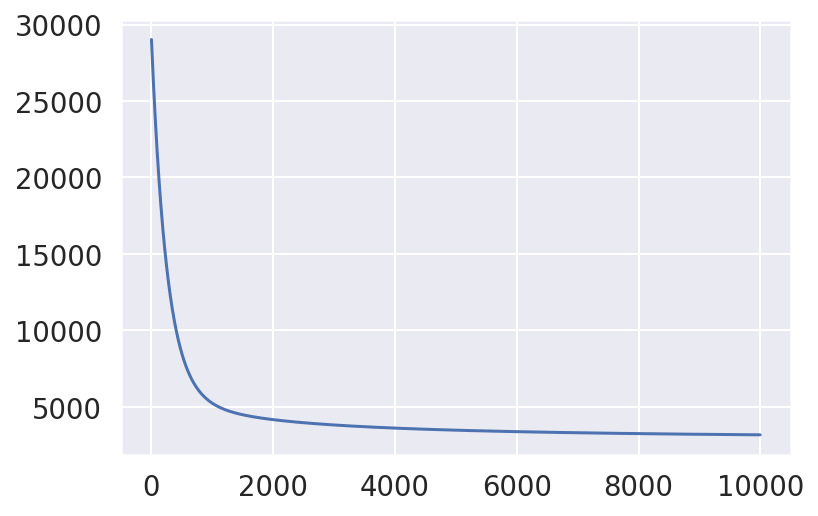



##### 초기 학습률:  0.0001  #####

  **[Iteration 100] Loss:  28194.4861, LEARNING_RATE:  0.00010
  **[Iteration 200] Loss:  27313.5309, LEARNING_RATE:  0.00010
  **[Iteration 300] Loss:  26470.2952, LEARNING_RATE:  0.00010
  **[Iteration 400] Loss:  25662.9958, LEARNING_RATE:  0.00010
  **[Iteration 500] Loss:  24889.9405, LEARNING_RATE:  0.00010
  **[Iteration 600] Loss:  24149.5232, LEARNING_RATE:  0.00010
  **[Iteration 700] Loss:  23440.2191, LEARNING_RATE:  0.00010
  **[Iteration 800] Loss:  22760.5808, LEARNING_RATE:  0.00010
  **[Iteration 900] Loss:  22109.2334, LEARNING_RATE:  0.00010
  **[Iteration 1000] Loss:  21484.8712, LEARNING_RATE:  0.00010
  **[Iteration 1100] Loss:  20886.2534, LEARNING_RATE:  0.00009
  **[Iteration 1200] Loss:  20312.2013, LEARNING_RATE:  0.00009
  **[Iteration 1300] Loss:  19761.5947, LEARNING_RATE:  0.00009
  **[Iteration 1400] Loss:  19233.3684, LEARNING_RATE:  0.00009
  **[Iteration 1500] Loss:  18726.5099, LEARNING_RATE:  0.00009
  **[Iteration 16

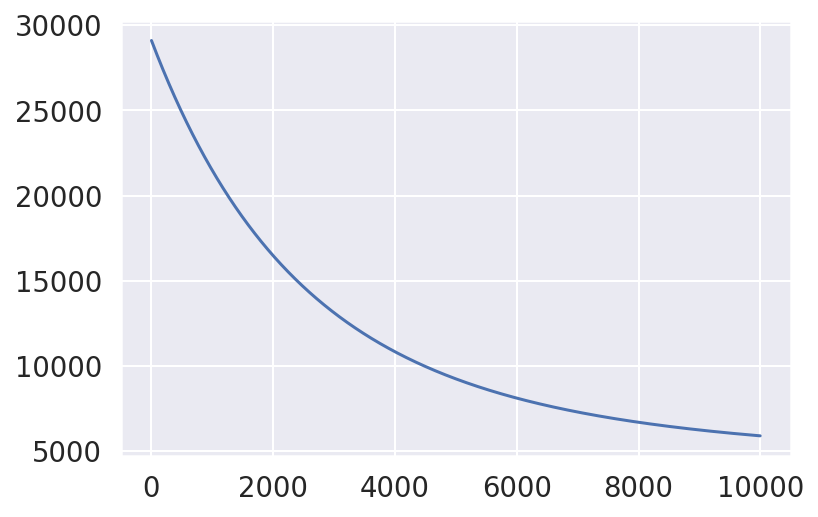

In [649]:

################################################ 지수기반 스케줄러로 학습률 설정 ########################################
############################### 반복횟수10000 고정하고 초기학습률 [0.1,0.01,0.001,0.0001] 적용 ###########################


# 지수기반 스케줄러
def exponential_decay(init_lr, step):
  def exponential_decay_fn(epoch):
    return init_lr * 0.1 ** (epoch / step)
  return exponential_decay_fn

 

init_lr_list = [0.1,0.01,0.001,0.0001]
max_epoch = 10000
step = random.randint(max_epoch/2,max_epoch*5) # 100 epochs 값이 필요할때 s는 50~500 사이 권장 # 1000 epochs 값이 필요할때 500~5000 사이
  
for lr in init_lr_list:
  print('======='*10)
  print('##### 초기 학습률: ',lr,' #####\n')
  W = copy.deepcopy(W_origin)
  b = copy.deepcopy(b_origin)
  losses = []
  for epoch in range(1, max_epoch):
        dW, db = gradient(X_train, W, b, y_train)
        LEARNING_RATE = exponential_decay(lr, step)(epoch)
        W -= LEARNING_RATE * dW
        b -= LEARNING_RATE * db
        L = loss(X_train, W, b, y_train)
        losses.append(L)
        if epoch % 100 == 0:
          print(f'  **[Iteration {epoch}] Loss: {L: 0.4f}, LEARNING_RATE: {LEARNING_RATE: 0.5f}' )
  prediction = model(X_train, W, b)
  mse = loss(X_train, W, b, y_train)
  print('##### 평균mse값: ',mse,' #####\n')

  print('\n')
  plt.plot(losses)
  plt.show()
  print('\n')
  
  

##### 초기 학습률:  0.1  #####

  **[Iteration 1000] Loss:  2932.3834, LEARNING_RATE:  0.09745
  **[Iteration 2000] Loss:  2929.4722, LEARNING_RATE:  0.09496
  **[Iteration 3000] Loss:  2928.2670, LEARNING_RATE:  0.09254
  **[Iteration 4000] Loss:  2927.4879, LEARNING_RATE:  0.09018
  **[Iteration 5000] Loss:  2926.8792, LEARNING_RATE:  0.08788
  **[Iteration 6000] Loss:  2926.3763, LEARNING_RATE:  0.08564
  **[Iteration 7000] Loss:  2925.9537, LEARNING_RATE:  0.08345
  **[Iteration 8000] Loss:  2925.5960, LEARNING_RATE:  0.08133
  **[Iteration 9000] Loss:  2925.2920, LEARNING_RATE:  0.07925
  **[Iteration 10000] Loss:  2925.0327, LEARNING_RATE:  0.07723
  **[Iteration 11000] Loss:  2924.8107, LEARNING_RATE:  0.07526
  **[Iteration 12000] Loss:  2924.6200, LEARNING_RATE:  0.07334
  **[Iteration 13000] Loss:  2924.4557, LEARNING_RATE:  0.07147
  **[Iteration 14000] Loss:  2924.3137, LEARNING_RATE:  0.06965
  **[Iteration 15000] Loss:  2924.1906, LEARNING_RATE:  0.06787
  **[Iteration 16000] 

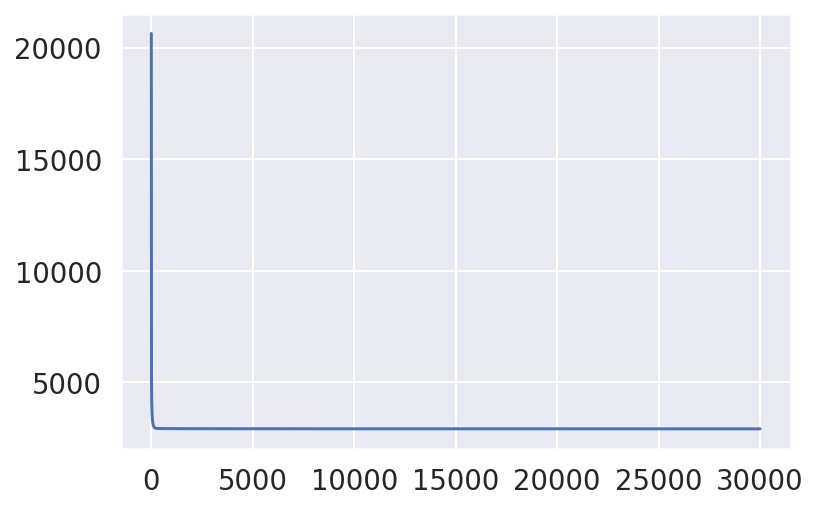



##### 초기 학습률:  0.01  #####

  **[Iteration 1000] Loss:  3084.5768, LEARNING_RATE:  0.00974
  **[Iteration 2000] Loss:  2958.1519, LEARNING_RATE:  0.00950
  **[Iteration 3000] Loss:  2941.5939, LEARNING_RATE:  0.00925
  **[Iteration 4000] Loss:  2938.0322, LEARNING_RATE:  0.00902
  **[Iteration 5000] Loss:  2936.5262, LEARNING_RATE:  0.00879
  **[Iteration 6000] Loss:  2935.5200, LEARNING_RATE:  0.00856
  **[Iteration 7000] Loss:  2934.7209, LEARNING_RATE:  0.00835
  **[Iteration 8000] Loss:  2934.0498, LEARNING_RATE:  0.00813
  **[Iteration 9000] Loss:  2933.4746, LEARNING_RATE:  0.00793
  **[Iteration 10000] Loss:  2932.9764, LEARNING_RATE:  0.00772
  **[Iteration 11000] Loss:  2932.5420, LEARNING_RATE:  0.00753
  **[Iteration 12000] Loss:  2932.1609, LEARNING_RATE:  0.00733
  **[Iteration 13000] Loss:  2931.8250, LEARNING_RATE:  0.00715
  **[Iteration 14000] Loss:  2931.5272, LEARNING_RATE:  0.00696
  **[Iteration 15000] Loss:  2931.2621, LEARNING_RATE:  0.00679
  **[Iteration 1600

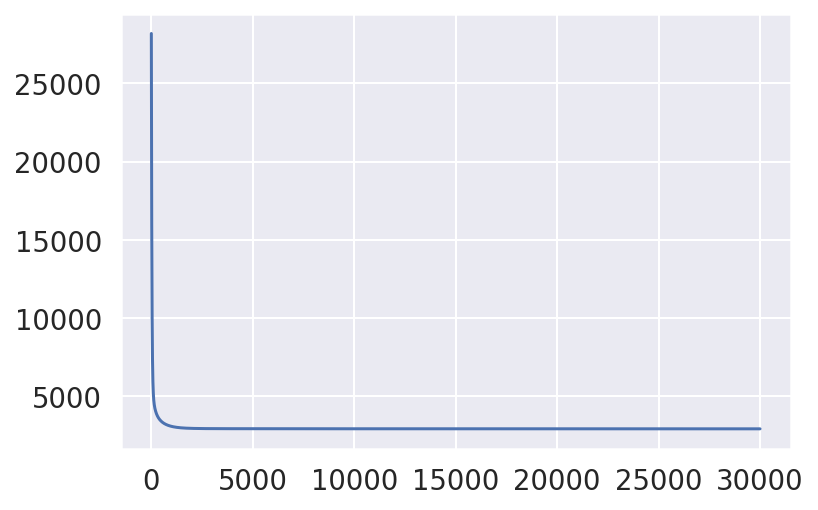



##### 초기 학습률:  0.001  #####

  **[Iteration 1000] Loss:  5203.0416, LEARNING_RATE:  0.00097
  **[Iteration 2000] Loss:  4135.4584, LEARNING_RATE:  0.00095
  **[Iteration 3000] Loss:  3782.0122, LEARNING_RATE:  0.00093
  **[Iteration 4000] Loss:  3573.3189, LEARNING_RATE:  0.00090
  **[Iteration 5000] Loss:  3434.6654, LEARNING_RATE:  0.00088
  **[Iteration 6000] Loss:  3335.7893, LEARNING_RATE:  0.00086
  **[Iteration 7000] Loss:  3261.8325, LEARNING_RATE:  0.00083
  **[Iteration 8000] Loss:  3204.7496, LEARNING_RATE:  0.00081
  **[Iteration 9000] Loss:  3159.7621, LEARNING_RATE:  0.00079
  **[Iteration 10000] Loss:  3123.7904, LEARNING_RATE:  0.00077
  **[Iteration 11000] Loss:  3094.7187, LEARNING_RATE:  0.00075
  **[Iteration 12000] Loss:  3071.0240, LEARNING_RATE:  0.00073
  **[Iteration 13000] Loss:  3051.5739, LEARNING_RATE:  0.00071
  **[Iteration 14000] Loss:  3035.5073, LEARNING_RATE:  0.00070
  **[Iteration 15000] Loss:  3022.1592, LEARNING_RATE:  0.00068
  **[Iteration 160

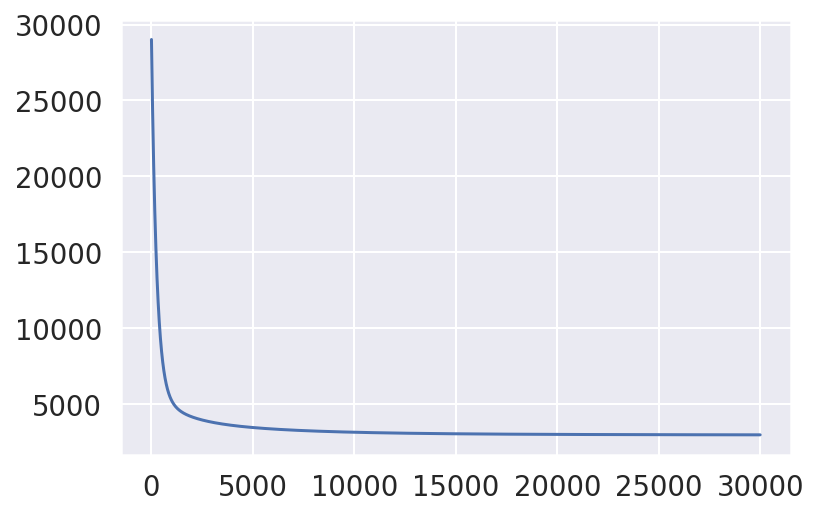



##### 초기 학습률:  0.0001  #####

  **[Iteration 1000] Loss:  21415.2500, LEARNING_RATE:  0.00010
  **[Iteration 2000] Loss:  16292.8189, LEARNING_RATE:  0.00009
  **[Iteration 3000] Loss:  12841.5122, LEARNING_RATE:  0.00009
  **[Iteration 4000] Loss:  10485.3725, LEARNING_RATE:  0.00009
  **[Iteration 5000] Loss:  8854.6299, LEARNING_RATE:  0.00009
  **[Iteration 6000] Loss:  7709.5169, LEARNING_RATE:  0.00009
  **[Iteration 7000] Loss:  6893.0331, LEARNING_RATE:  0.00008
  **[Iteration 8000] Loss:  6301.3754, LEARNING_RATE:  0.00008
  **[Iteration 9000] Loss:  5865.2521, LEARNING_RATE:  0.00008
  **[Iteration 10000] Loss:  5537.9663, LEARNING_RATE:  0.00008
  **[Iteration 11000] Loss:  5287.7476, LEARNING_RATE:  0.00008
  **[Iteration 12000] Loss:  5092.7741, LEARNING_RATE:  0.00007
  **[Iteration 13000] Loss:  4937.9123, LEARNING_RATE:  0.00007
  **[Iteration 14000] Loss:  4812.5649, LEARNING_RATE:  0.00007
  **[Iteration 15000] Loss:  4709.2373, LEARNING_RATE:  0.00007
  **[Iteratio

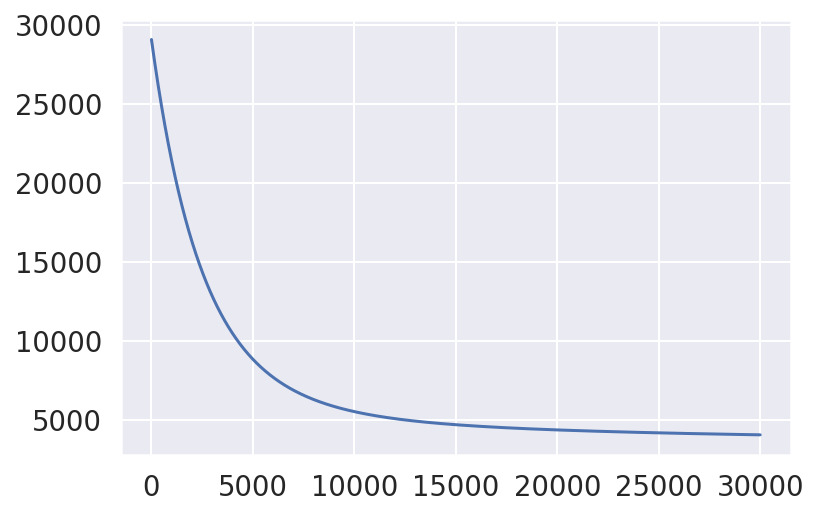

In [650]:

################################################ 지수기반 스케줄러로 학습률 설정 ########################################
############################### 반복횟수30000 고정하고 초기학습률 [0.1,0.01,0.001,0.0001] 적용 ###########################


# 지수기반 스케줄러
def exponential_decay(init_lr, step):
  def exponential_decay_fn(epoch):
    return init_lr * 0.1 ** (epoch / step)
  return exponential_decay_fn

 

init_lr_list = [0.1,0.01,0.001,0.0001]
max_epoch = 30000
step = random.randint(max_epoch/2,max_epoch*5) # 100 epochs 값이 필요할때 s는 50~500 사이 권장 # 1000 epochs 값이 필요할때 500~5000 사이
  
for lr in init_lr_list:
  print('======='*10)
  print('##### 초기 학습률: ',lr,' #####\n')
  W = copy.deepcopy(W_origin)
  b = copy.deepcopy(b_origin)
  losses = []
  for epoch in range(1, max_epoch):
        dW, db = gradient(X_train, W, b, y_train)
        LEARNING_RATE = exponential_decay(lr, step)(epoch)
        W -= LEARNING_RATE * dW
        b -= LEARNING_RATE * db
        L = loss(X_train, W, b, y_train)
        losses.append(L)
        if epoch % 1000 == 0:
          print(f'  **[Iteration {epoch}] Loss: {L: 0.4f}, LEARNING_RATE: {LEARNING_RATE: 0.5f}' )
  prediction = model(X_train, W, b)
  mse = loss(X_train, W, b, y_train)
  print('##### 평균mse값: ',mse,' #####\n')

  print('\n')
  plt.plot(losses)
  plt.show()
  print('\n')
  
  

<div>
위에서 직접 학습률을 지정해본 결과처럼 그래프와 에포크가 고정되어있을때 초기 학습률을 높게 셋팅할수록 낮은 loss값을 얻었다. 학습률을 너무 낮게 설정해도 에포크가 고정되어있으면 제대로 loss를 줄이지못하고 학습을 끝낼수있다는것을 알 수 있다. 또한 같은 학습률일때는 학습횟수가 높은것이 더 빨리 loss 줄일수있었다. 하지만 학습횟수는 특정 횟수를 지나면 loss값이 특정값에 수렴하기에 큰 학습횟수가 좋은것만은 아니다. 성능이 제일 좋은것은 에포크:30000, 학습률:0.1 이다.  
</div>

#### **1-3-7. 모델 학습**

In [651]:

################################################ 지수기반 스케줄러로 학습률 설정 ########################################
############################### 반복횟수30000 고정하고 초기학습률 0.1 적용 ###########################


lr = 0.001
max_epoch = 100000
step = random.randint(max_epoch/2,max_epoch*5) # 100 epochs 값이 필요할때 s는 50~500 사이 권장 # 1000 epochs 값이 필요할때 500~5000 사이

print('======='*10)
print('##### 초기 학습률: ',lr,' #####\n')
W = copy.deepcopy(W_origin)
b = copy.deepcopy(b_origin)
losses = []
for epoch in range(1, max_epoch):
  dW, db = gradient(X_train, W, b, y_train)
  LEARNING_RATE = exponential_decay(lr, step)(epoch)
  W -= LEARNING_RATE * dW
  b -= LEARNING_RATE * db
  L = loss(X_train, W, b, y_train)
  losses.append(L)
  if epoch % 10000 == 0:
    print(f'  **[Iteration {epoch}] Loss: {L: 0.4f}, LEARNING_RATE: {LEARNING_RATE: 0.5f}' )




##### 초기 학습률:  0.001  #####

  **[Iteration 10000] Loss:  3092.0857, LEARNING_RATE:  0.00093
  **[Iteration 20000] Loss:  2961.8006, LEARNING_RATE:  0.00087
  **[Iteration 30000] Loss:  2943.0828, LEARNING_RATE:  0.00081
  **[Iteration 40000] Loss:  2938.8769, LEARNING_RATE:  0.00075
  **[Iteration 50000] Loss:  2937.2500, LEARNING_RATE:  0.00070
  **[Iteration 60000] Loss:  2936.2835, LEARNING_RATE:  0.00065
  **[Iteration 70000] Loss:  2935.5716, LEARNING_RATE:  0.00061
  **[Iteration 80000] Loss:  2934.9987, LEARNING_RATE:  0.00056
  **[Iteration 90000] Loss:  2934.5199, LEARNING_RATE:  0.00053


In [652]:

################################################ 지수기반 스케줄러로 학습률 설정 ########################################
############################### 반복횟수30000 고정하고 초기학습률 0.1 적용 ###########################


lr = 0.1
max_epoch = 30000
step = random.randint(max_epoch/2,max_epoch*5) # 100 epochs 값이 필요할때 s는 50~500 사이 권장 # 1000 epochs 값이 필요할때 500~5000 사이

print('======='*10)
print('##### 초기 학습률: ',lr,' #####\n')
W = copy.deepcopy(W_origin)
b = copy.deepcopy(b_origin)
losses = []
for epoch in range(1, max_epoch):
      dW, db = gradient(X_train, W, b, y_train)
      LEARNING_RATE = exponential_decay(lr, step)(epoch)
      W -= LEARNING_RATE * dW
      b -= LEARNING_RATE * db
      L = loss(X_train, W, b, y_train)
      losses.append(L)
      if epoch % 1000 == 0:
        print(f'  **[Iteration {epoch}] Loss: {L: 0.4f}, LEARNING_RATE: {LEARNING_RATE: 0.5f}' )




##### 초기 학습률:  0.1  #####

  **[Iteration 1000] Loss:  2932.3646, LEARNING_RATE:  0.09817
  **[Iteration 2000] Loss:  2929.4474, LEARNING_RATE:  0.09637
  **[Iteration 3000] Loss:  2928.2358, LEARNING_RATE:  0.09461
  **[Iteration 4000] Loss:  2927.4464, LEARNING_RATE:  0.09288
  **[Iteration 5000] Loss:  2926.8261, LEARNING_RATE:  0.09118
  **[Iteration 6000] Loss:  2926.3118, LEARNING_RATE:  0.08951
  **[Iteration 7000] Loss:  2925.8789, LEARNING_RATE:  0.08787
  **[Iteration 8000] Loss:  2925.5126, LEARNING_RATE:  0.08626
  **[Iteration 9000] Loss:  2925.2015, LEARNING_RATE:  0.08468
  **[Iteration 10000] Loss:  2924.9366, LEARNING_RATE:  0.08313
  **[Iteration 11000] Loss:  2924.7103, LEARNING_RATE:  0.08161
  **[Iteration 12000] Loss:  2924.5166, LEARNING_RATE:  0.08012
  **[Iteration 13000] Loss:  2924.3504, LEARNING_RATE:  0.07865
  **[Iteration 14000] Loss:  2924.2074, LEARNING_RATE:  0.07721
  **[Iteration 15000] Loss:  2924.0840, LEARNING_RATE:  0.07580
  **[Iteration 16000] 

### **1-4. 모델 평가**

#### **1-4-1. test 데이터에 대한 성능 확인**

In [653]:


prediction = model(X_test, W, b)
mse = loss(X_test, W, b, y_test)
print(mse)


2896.1232243542145


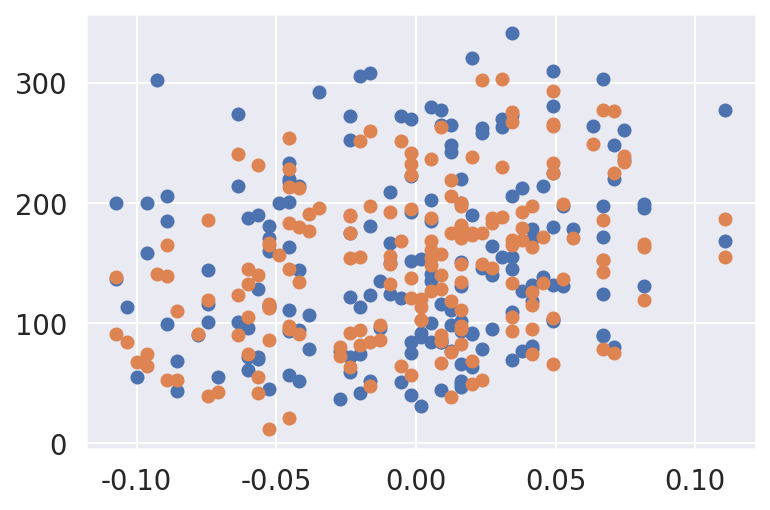

In [654]:
plt.scatter(X_test[:, 0], y_test, label="true")
plt.scatter(X_test[:, 0], prediction, label="pred")
plt.show()

산점도를 확인하니 잘 일치하는 것을 잘맞는것을 알 수 있다.

## **Project 2. 자전거 대여량 예측: 날씨 좋은 월요일 오후 세 시, 자전거 타는 사람은 몇 명?**
---


### **2-0. 문제 정의**

#### **2-0.1. 프로젝트 목표**  
<div>
이번 프로젝트는 시간당 자전거 대여량을 예측하는 Bike Sharing Demand 경진대회. 워싱턴 D.C 소재의 자전거 대여 스타트업 Capital Bikeshare의 데이터를 활용하여, 특정 시간대에 얼마나 많은 사람들이 자전거를 대여하는지 예측하는 것이 목표이다. 
<br>
사람들이 자전거를 대여하는데는 많은 요소가 관여되어 있을 것이다. 시간, 날씨, 근무일여부와 같은 요소를 조합하여 자전거 대여량을 예측하고자한다. 
</div>


#### **2-0.2. 분석 데이터 정의** 
<div> 
데이터는 Kaggle의 Bike Sharing Demand 경진대회에서 제공되는 것을 이용하였다. 

<br>
데이터셋의 세부적인 구성은 아래 표에서 확인할 수 있다. 
<br>
</br>

| 컬럼 | 설명 |
| --- | --- |
| datetime | 시간. 연-월-일 시:분:초 로 표현  |
| season | 계절. 봄(1), 여름(2), 가을(3), 겨울(4)   |
| holiday | 공휴일. 1이면 공휴일, 0이면 공휴일이 아님 |
| workingday | 근무일. 1이면 근무일, 0이면 근무일이 아님 |
| weather | 날씨. 1 ~ 4 사이의 값을 가짐|
| temp |  온도. 섭씨(Celsius) |
| atemp | 체감 온도. 섭씨(Celsius)|
| humidity | 습도 |
| windspeed | 풍속 |
| casual | 비회원(non-registered)의 자전거 대여량 |
| registered | 회원(registered)의 자전거 대여량 
| count | 총 자전거 대여랑. 비회원(casual) + 회원(registered) |
</div> 





#### **2-0.3. 모델링 task 정의**  
<div>
feature들의 값으로 실수형 데이터를 예측하는 선형 회귀에 속한다. 직접 손실함수와 기울기를 계산하지 않고도 (빠르고 간편하게) 패키지를 활용해 선형회귀를 구현하는 방법을 익히는 것이 목표이다. 해당 프로젝트는 sklearn의 LinearRegression을 활용해 진행하였다. <br> 
</div> 


### **2-1. 데이터 불러오기**

In [769]:
############################## 데이터 로드 & 확인 ##############################

root = "data/bike-sharing-demand/"

train = pd.read_csv('/content/train.csv', parse_dates=["datetime"])
test = pd.read_csv('/content/test.csv', parse_dates=["datetime"])


In [770]:
print(f' *train데이터 크기 : {train.shape}\n')
train.head()

 *train데이터 크기 : (10886, 12)



,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.39,81,0.00,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.63,80,0.00,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.63,80,0.00,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.39,75,0.00,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.39,75,0.00,0,1,1


In [771]:
print(f' *test데이터 크기 : {test.shape}\n')
test.head()

 *test데이터 크기 : (6493, 9)



,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.37,56,26.00
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.63,56,0.00
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.63,56,0.00
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.88,56,11.00
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.88,56,11.00


### **2-2. 탐색적 데이터 분석 및 전처리**


#### **2-2-1. 데이터 타입 & 갯수 확인**

In [772]:
############################## 컬럼별 데이터 타입확인 ##############################
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [773]:
############################## feature별 unique값 갯수 확인 ##############################
[(f"{col} :", len(train[col].unique())) for col in train]

[('datetime :', 10886),
 ('season :', 4),
 ('holiday :', 2),
 ('workingday :', 2),
 ('weather :', 4),
 ('temp :', 49),
 ('atemp :', 60),
 ('humidity :', 89),
 ('windspeed :', 28),
 ('casual :', 309),
 ('registered :', 731),
 ('count :', 822)]

데이터타입을 확인해보면 범주형인데 실수형으로 되어있는것들이 보인다. 우선 지금은 이런 상황인것을 확인만 하고 넘어가도록 하겠다. 

#### **2-2-2. 통계값 확인**

In [774]:
############################## 컬럼별 간단한 통계값 확인 ##############################
# 지수표현식에서 실수표현식으로 표기하기 위해 실수자릿수 설정
pd.options.display.float_format = '{:.2f}'.format

train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00
mean,2.51,0.03,0.68,1.42,20.23,23.66,61.89,12.80,36.02,155.55,191.57
std,1.12,0.17,0.47,0.63,7.79,8.47,19.25,8.16,49.96,151.04,181.14
min,1.00,0.00,0.00,1.00,0.82,0.76,0.00,0.00,0.00,0.00,1.00
25%,2.00,0.00,0.00,1.00,13.94,16.66,47.00,7.00,4.00,36.00,42.00
50%,3.00,0.00,1.00,1.00,20.50,24.24,62.00,13.00,17.00,118.00,145.00
75%,4.00,0.00,1.00,2.00,26.24,31.06,77.00,17.00,49.00,222.00,284.00
max,4.00,1.00,1.00,4.00,41.00,45.45,100.00,57.00,367.00,886.00,977.00


데이터의 누락없이 feature 별 count도 모두 동일하고 데이터에는 우선 큰 문제는 없어보인다.

#### **2-2-3. 결측값 확인**

In [775]:
############################## 결측여부 확인 ##############################
train.isnull().any().any()

False

#### **2-2-4. 중복값 확인**

In [776]:
############################## 중복된 항목 수 확인 ##############################
print("중복된 항목 수 :", len(train[train.duplicated()])) 

중복된 항목 수 : 0


#### **2-2-5. 변수간 상관관계 파악**

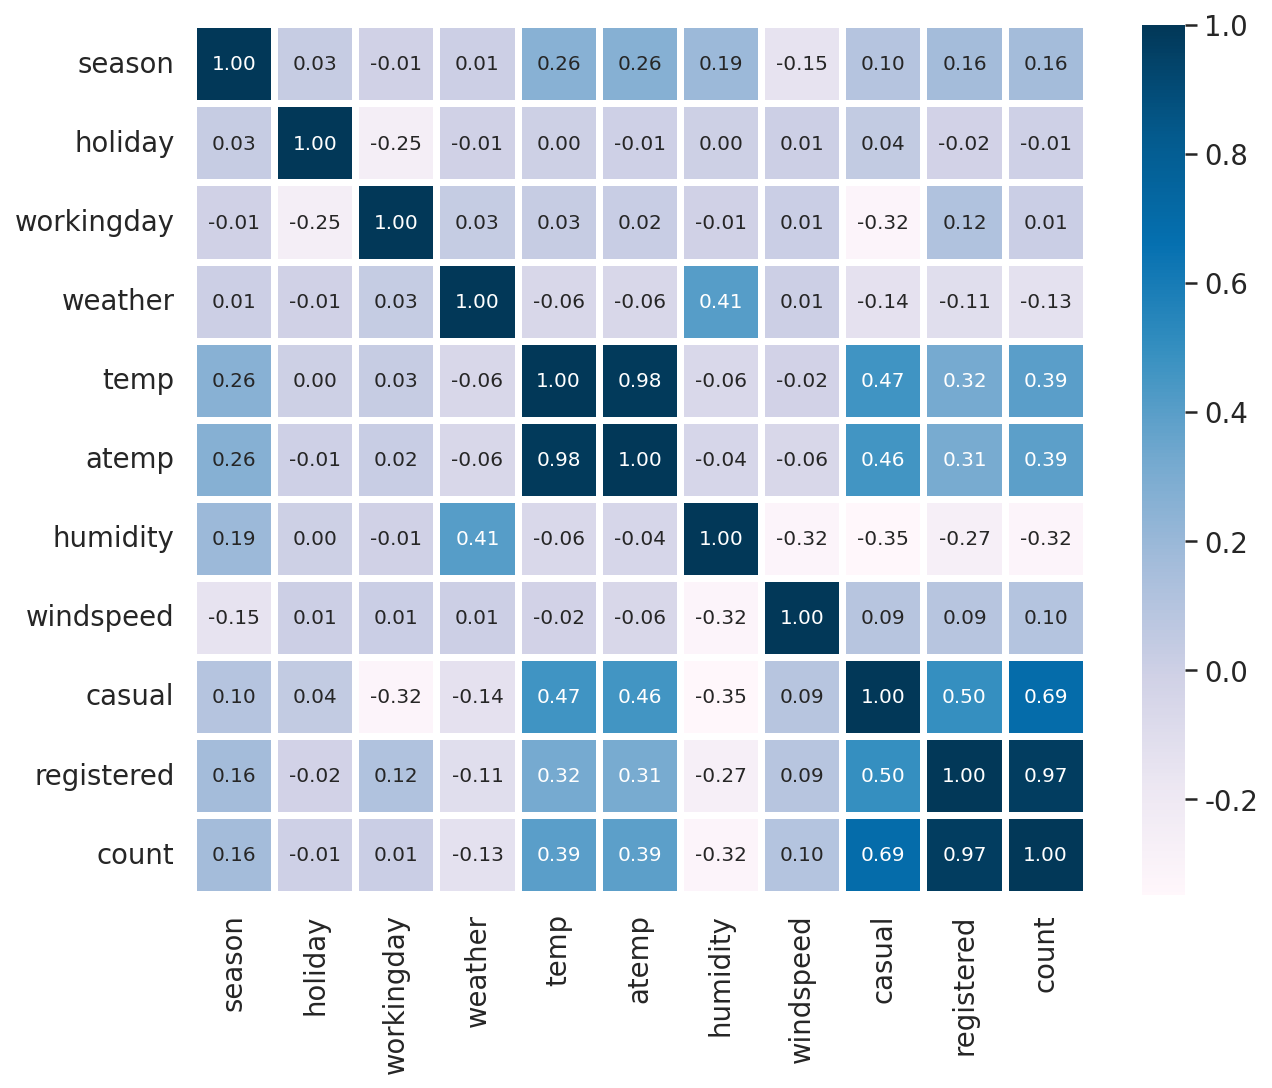

In [777]:
############################## 전체 데이터 상관관계 표시 ##############################
draw_corrmap(train)

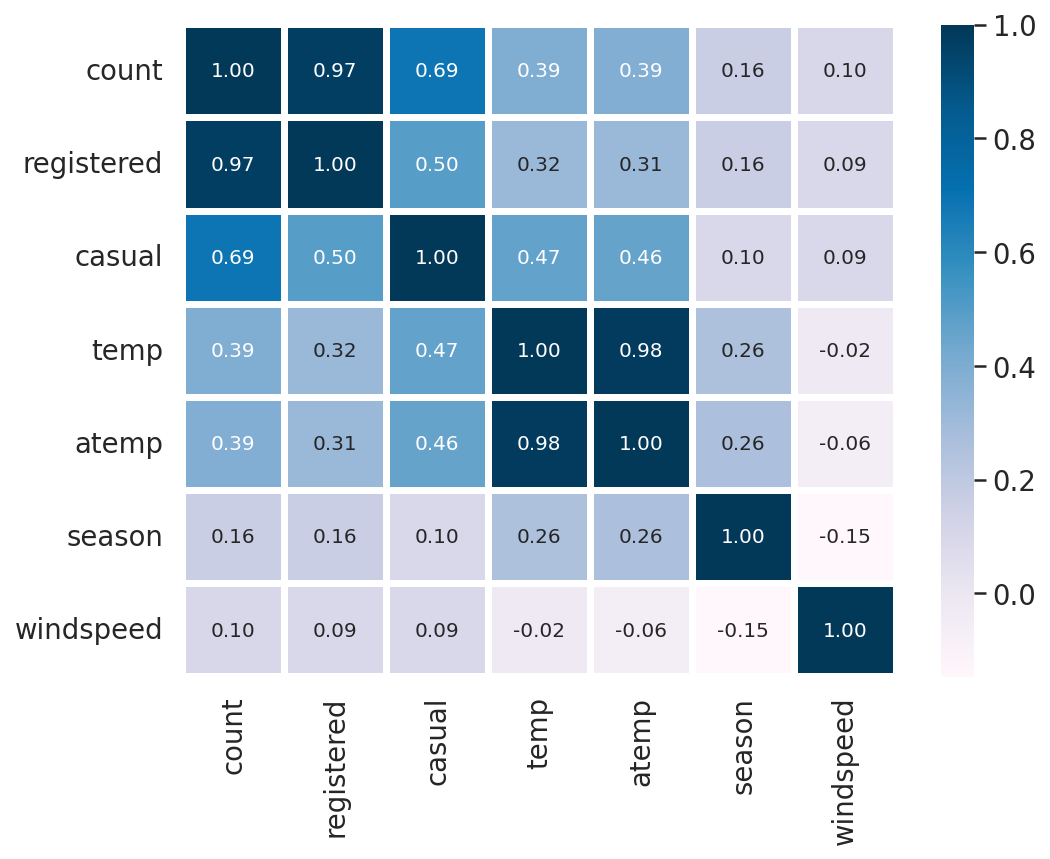

In [778]:
############################## label 기준으로 상관관계 top5 표시 ##############################
draw_top_corrmap(train,'count',7)

<div>
count 는 registerted + casual 의 합이기 때문에 당연히 casual과 registerted count와 완전 강한 상관관계를 보인다. registerted괴 casual 는 나중에 다중공선성 문제의 방지로 삭제해주는것도 좋은 방법이다. </div>

#### **2-2-6. feature(독립변수) 확인&정제**

In [779]:
############################## datetime 전처리 ##############################

# datetime 형변환 
train['datetime'] = pd.to_datetime(train['datetime'], format="%Y-%d-%m %H:%M:%S")

# 연, 월, 일, 시, 분, 초, 요일 컬럼 생성
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.day
train["hour"] = train["datetime"].dt.hour
train["minute"] = train["datetime"].dt.minute
train["second"] = train["datetime"].dt.second


############################### 요일 datetime-dayofweek(str) 컬럼에 추가 ##############################
train["dayofweek"] = train["datetime"].dt.dayofweek #0(월), 1(화), 2(수), 3(목), 4(금), 5(토), 6(일) 
train.loc[train["dayofweek"] == 0, "dayofweek(str)"] = "Monday"
train.loc[train["dayofweek"] == 1, "dayofweek(str)"] = "Tuesday"
train.loc[train["dayofweek"] == 2, "dayofweek(str)"] = "Wednesday"
train.loc[train["dayofweek"] == 3, "dayofweek(str)"] = "Thursday"
train.loc[train["dayofweek"] == 4, "dayofweek(str)"] = "Friday"
train.loc[train["dayofweek"] == 5, "dayofweek(str)"] = "Saturday"
train.loc[train["dayofweek"] == 6, "dayofweek(str)"] = "Sunday"


<div>날짜 컬럼은 여러개의 숫자로 구성되어 있는것처럼 보인다. (ex: 2022-01-01 00:00:00) 하지만 숫자형은 아니며, 판다스에서는 문자열(object) 또는 날짜(datetime64)로 인식한다. (값에 하이픈(-)과 콜론(:)이 있기때문이다.). </div>

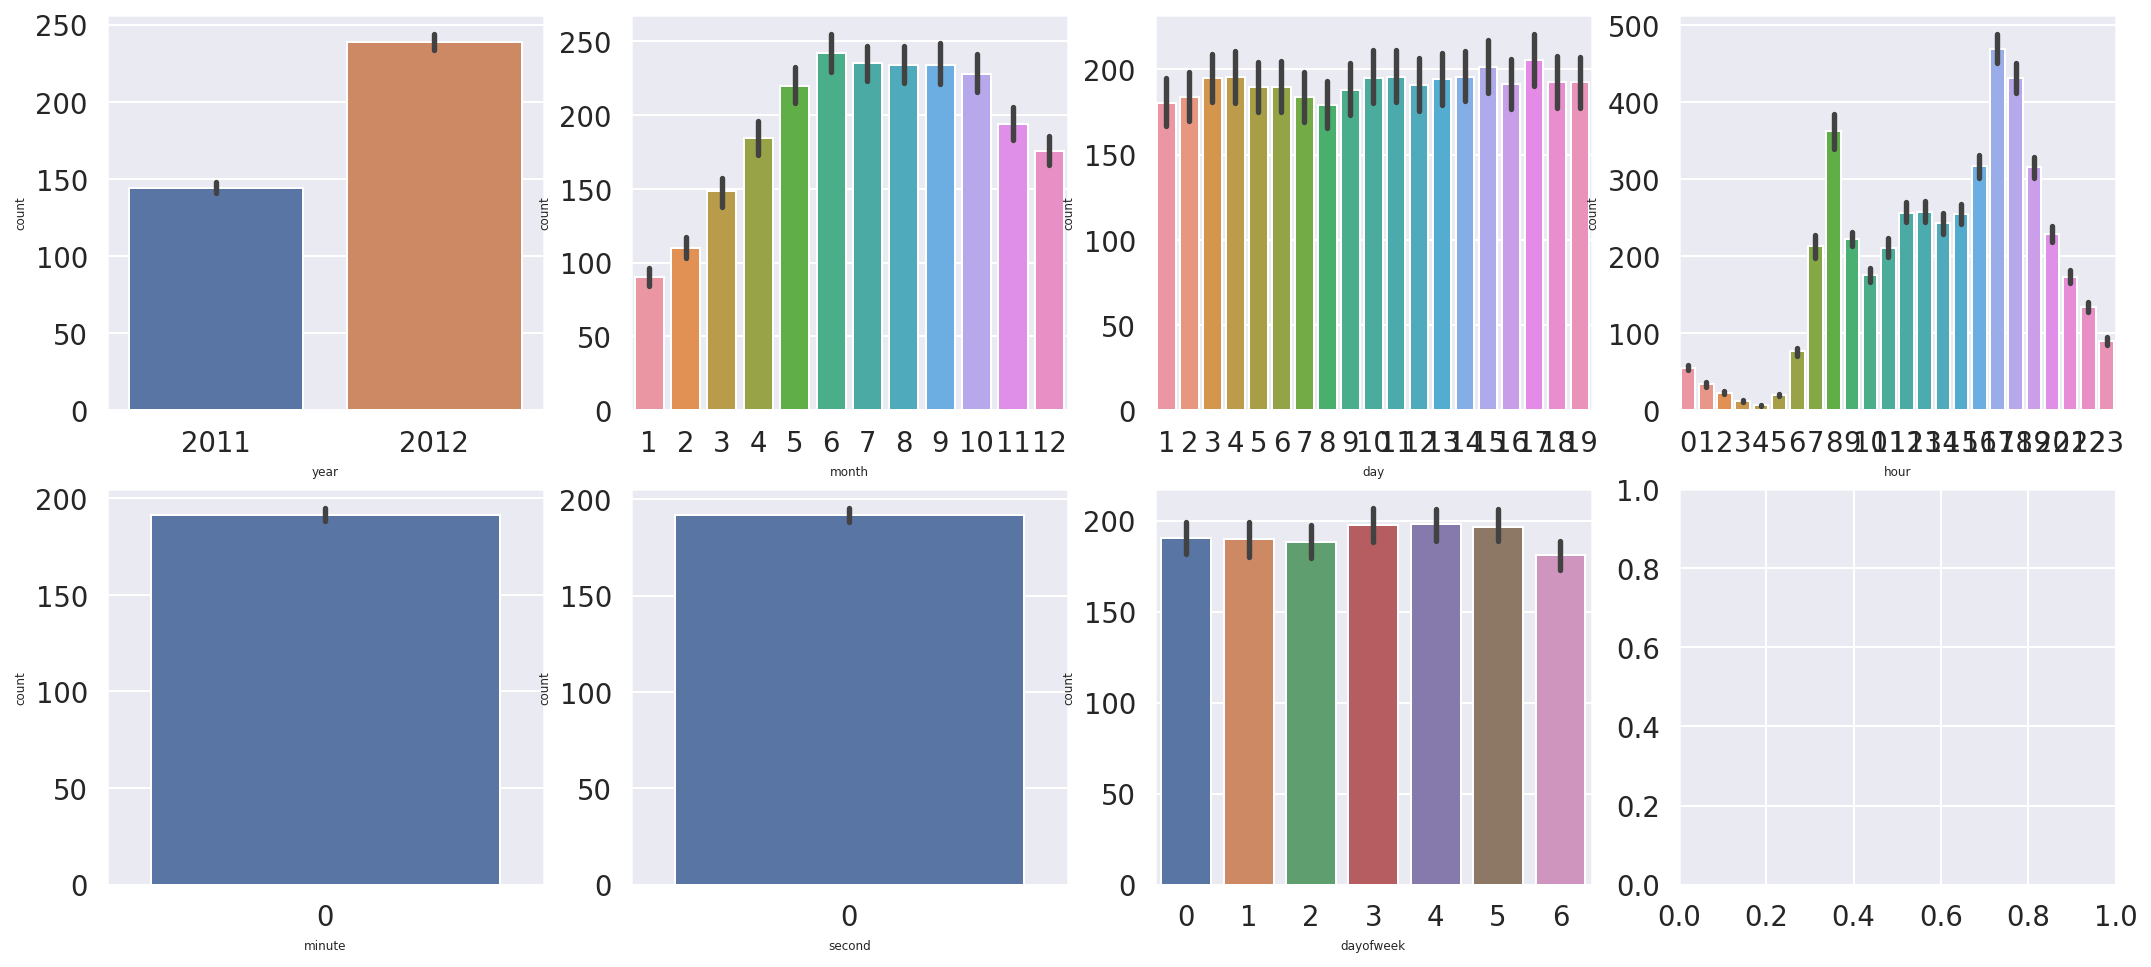

In [780]:
############################## 날짜 & 대여량 시각화  ##############################

figure, ((ax1, ax2, ax3,ax4), (ax5, ax6, ax7,_)) = plt.subplots(nrows=2, ncols=4)

figure.set_size_inches(18, 8)
sns.barplot(data=train, x="year", y="count", ax=ax1)
sns.barplot(data=train, x="month", y="count", ax=ax2)
sns.barplot(data=train, x="day", y="count", ax=ax3)
sns.barplot(data=train, x="hour", y="count", ax=ax4)
sns.barplot(data=train, x="minute", y="count", ax=ax5)
sns.barplot(data=train, x="second", y="count", ax=ax6)
sns.barplot(data=train, x="dayofweek", y="count", ax=ax7)

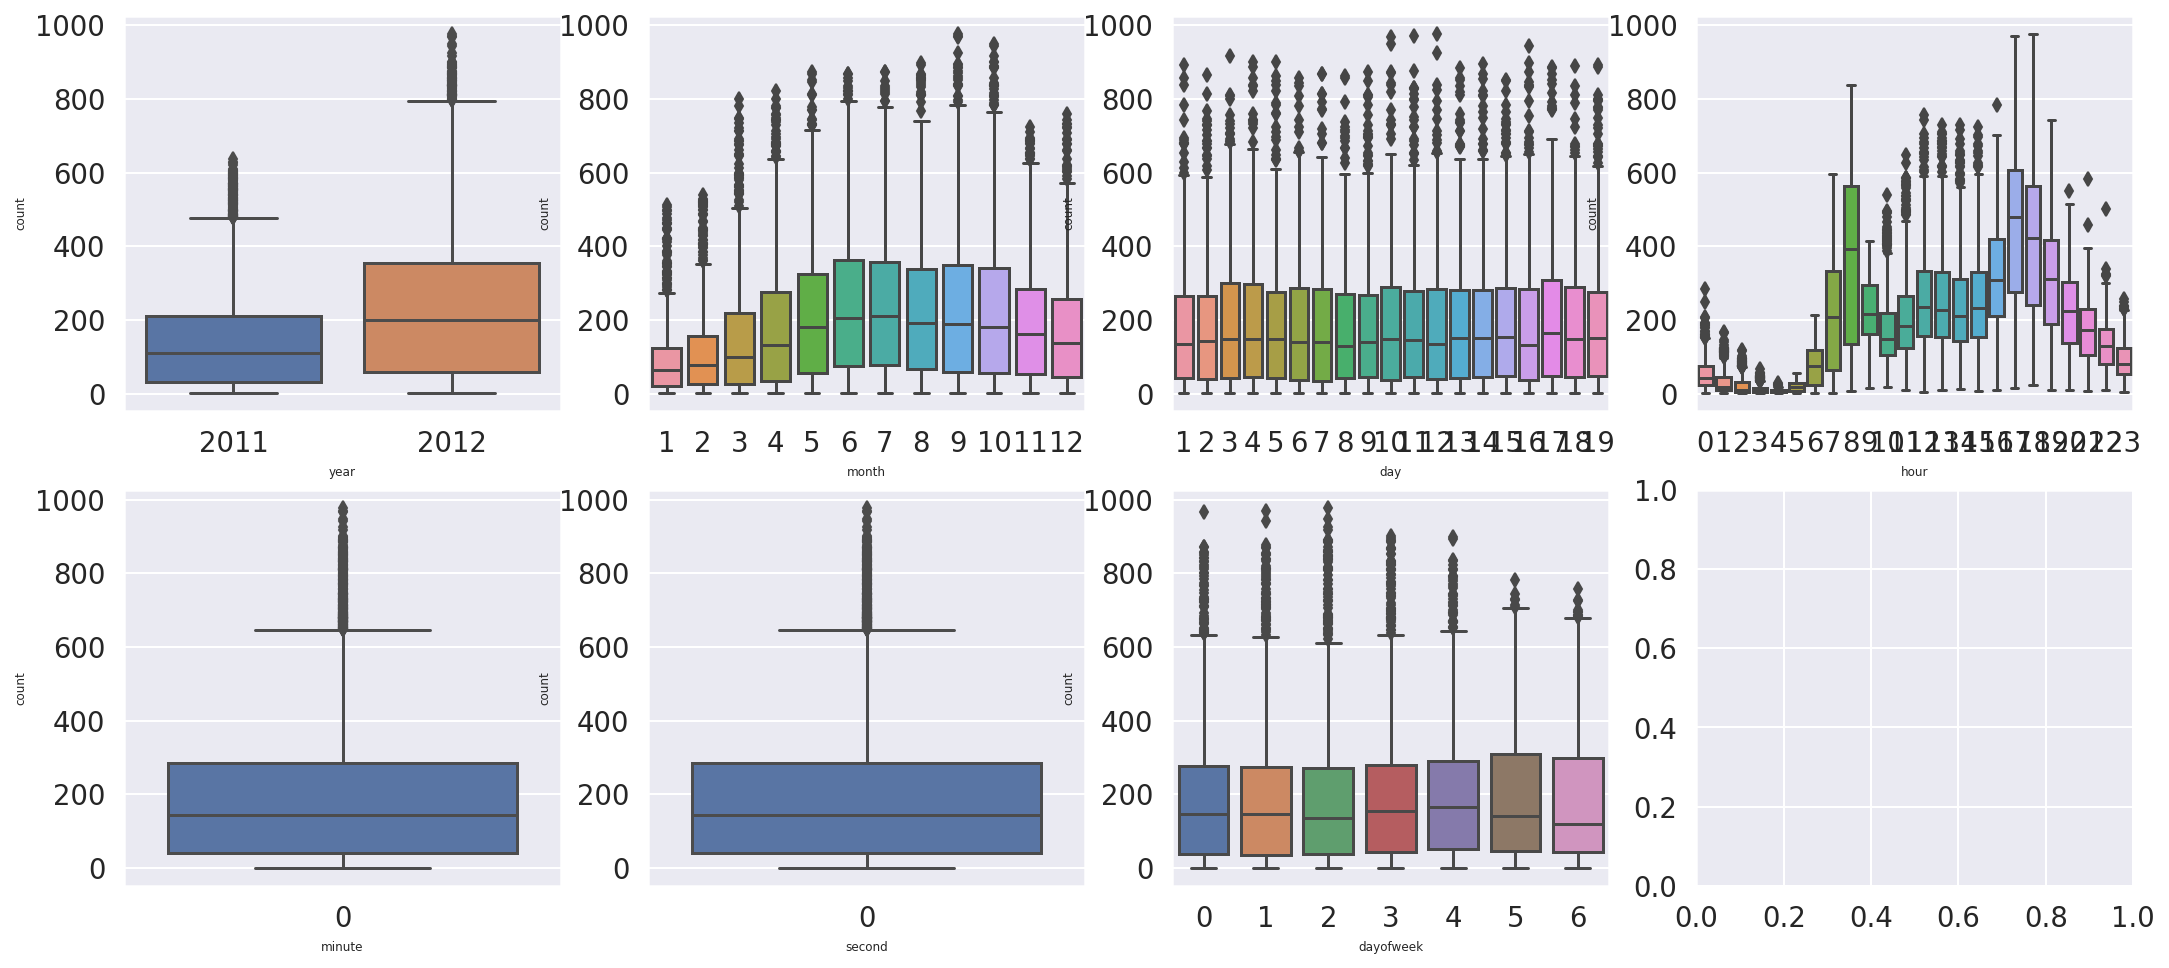

In [781]:
############################## 날짜 & 대여량 시각화  ##############################

figure, ((ax1, ax2, ax3,ax4), (ax5, ax6, ax7,_)) = plt.subplots(nrows=2, ncols=4)

figure.set_size_inches(18, 8)
sns.boxplot(data=train, x="year", y="count", ax=ax1)
sns.boxplot(data=train, x="month", y="count", ax=ax2)
sns.boxplot(data=train, x="day", y="count", ax=ax3)
sns.boxplot(data=train, x="hour", y="count", ax=ax4)
sns.boxplot(data=train, x="minute", y="count", ax=ax5)
sns.boxplot(data=train, x="second", y="count", ax=ax6)
sns.boxplot(data=train, x="dayofweek", y="count", ax=ax7)

<div>
이 시각화를 통해 다양한 것을 알아낼 수 있었는데, 특히 학습시 사용해야하며 사용하지 말아야할것은 무엇인지 명확하게 드러났다. 자세한 내용은 아래와 같다.
</div>
</br>
<div>
<strong>year</strong>
  </br> 2011년과 2012년의 대여량을 비교해보았을 때, 2012년의 대여량이 많이 늘었는데, 이는 대여회사의 인지도가 높아져서 회원이 늘어났을수도있다. 혹은 보유하고있는 자전거수를 늘려서 더 많은 사람들이 이용하게 했을 수 도있다. 
</div>
</br>
<div>
<strong>month</strong>
</br> 자전거 대여는 더운 여름에는 잘 이루어지지 않을 것 같은데 의외로 여름에 자전거 대여량이 많다. 또한 여름의 자전거 대여량은 비슷한 수준을 유지한다. 반면에 12월과 1월은 같은 계절인 겨울임에도 불구하고 대여량의 차이가 꽤 있는것을 알 수 있다. 12월이 1월보다 두배가량 대여량이 많다. 무슨이유가 있는지 한번 확인을 해보는것이 좋을것같다.
</br>
</div>
<div></br>
<strong>day</strong>
</br> day를 보면 보통은 1~31일까지로 구성되야하는데 현재 train데이터에는 1~19일으로만 구성된것을 알 수있다.
 아마도 test데이터에는 20~31일까지의 데이터로 구성되어있을 것이다. 이런 데이터를 모델학습시 사용하면 train데이터에만 과적합되기에 학습시 이 컬럼은 제외하는것이 좋을것같다. 
</div>
<div></br>
<strong>hour</strong>
</br> hour에서는 특히 도드라지는 부분이 명확히 보이는데, 이때 시간은 오전8시,오후7~8시인데 이때는 아마 출퇴근을 목적으로 이용한 시간이 많아져서 그런것같다. 출퇴근시간여부를 알려주는 컬럼을 하나 생성하면 좋을것같다.
</div>
<div>
</br>
<strong>minute,second</strong>
</br> 이두개의 변수를 보면 0값밖에 없는데, 이는 날짜데이터값이 *2011-01-01 00:00:00* 이런 형식으로 되어있기때문이다. 즉 날짜값에서 minute,second 은 기록되지 않는다.
</br> 
</br> 
<strong>dayofweek</strong>
</br> 주말에 대여량이 더 많을것이라 생각했는데 의외로 요일별로 고르게 대여를 하는것을 알 수 있다. 
</br> 
</br> 최종적으로 모델학습시에는 year, month, hour 만 사용하도록 하겠다.
</div>

In [783]:
################## year-month  조합한 컬럼생성 #######################

train["year_month"] = train["year"].astype('str') + train["month"].astype('str').str.zfill(2)

train[["datetime", "year_month"]].head(10)

,datetime,year_month
0,2011-01-01 00:00:00,201101
1,2011-01-01 01:00:00,201101
2,2011-01-01 02:00:00,201101
3,2011-01-01 03:00:00,201101
4,2011-01-01 04:00:00,201101
5,2011-01-01 05:00:00,201101
6,2011-01-01 06:00:00,201101
7,2011-01-01 07:00:00,201101
8,2011-01-01 08:00:00,201101
9,2011-01-01 09:00:00,201101


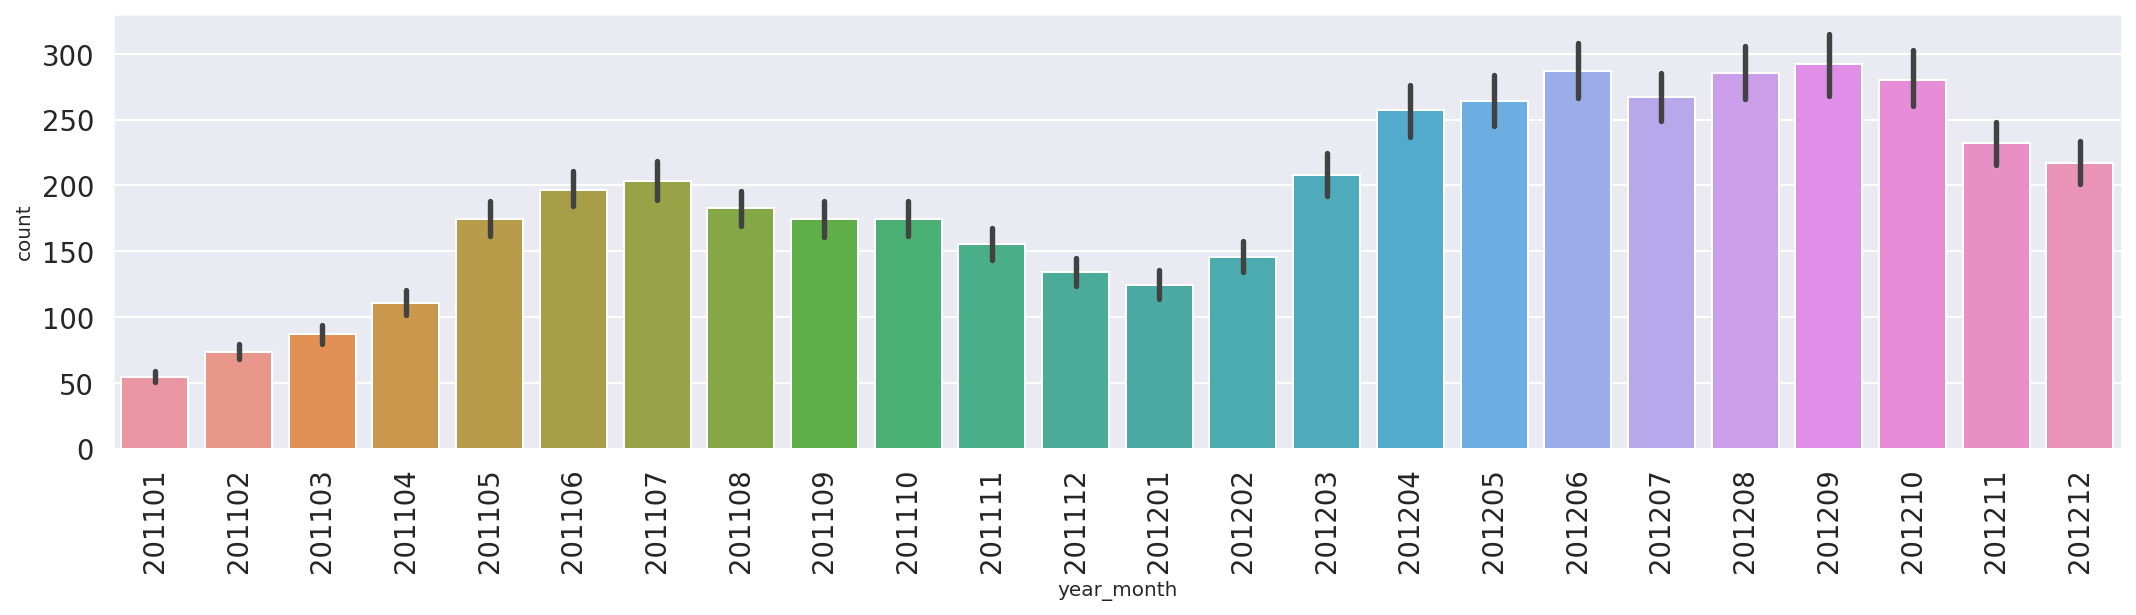

In [784]:
##################### year_month 시각화 #######################


plt.figure(figsize=(18, 4))
plt.rc('axes', labelsize=10)
plt.xticks(rotation =90) 
sns.barplot(data=train, x="year_month", y="count")


<div>
날짜 데이터를 좀 더 세부적으로 보기 위해 year+month /year+month+hour 을 합친 새로운 feature를 생성했다. 위에서 월별 대여량을 시각화했을때는 12월이 1월보다 대여량이 많아보였는데 이것은 2011년 자체가 대여량이 적은것이 문제였다. 특히 2011년 1월에는 특히 아직 잘 알려져있지않아서 그런지 제일 대여량이 적어서 2011년 1월과 2012년 1월을 합하니 적은 수가 나왔던것같다. 
</br>
각 월의 특성때문이 아니라 년도별로 대여량이 차이가 나는 것 때문에 월별로 대여량의 수가 차이가 많이 나는데 이 경우에는 학습시킬때 month를 넣으면 과적합될 수 있다. 따라서 month 컬럼을 원핫인코딩 시켜주거나, 해당 컬럼을 제외하고 학습시키도록 하겠다. 
</div> 

#### **2-2-7. target feature 확인**

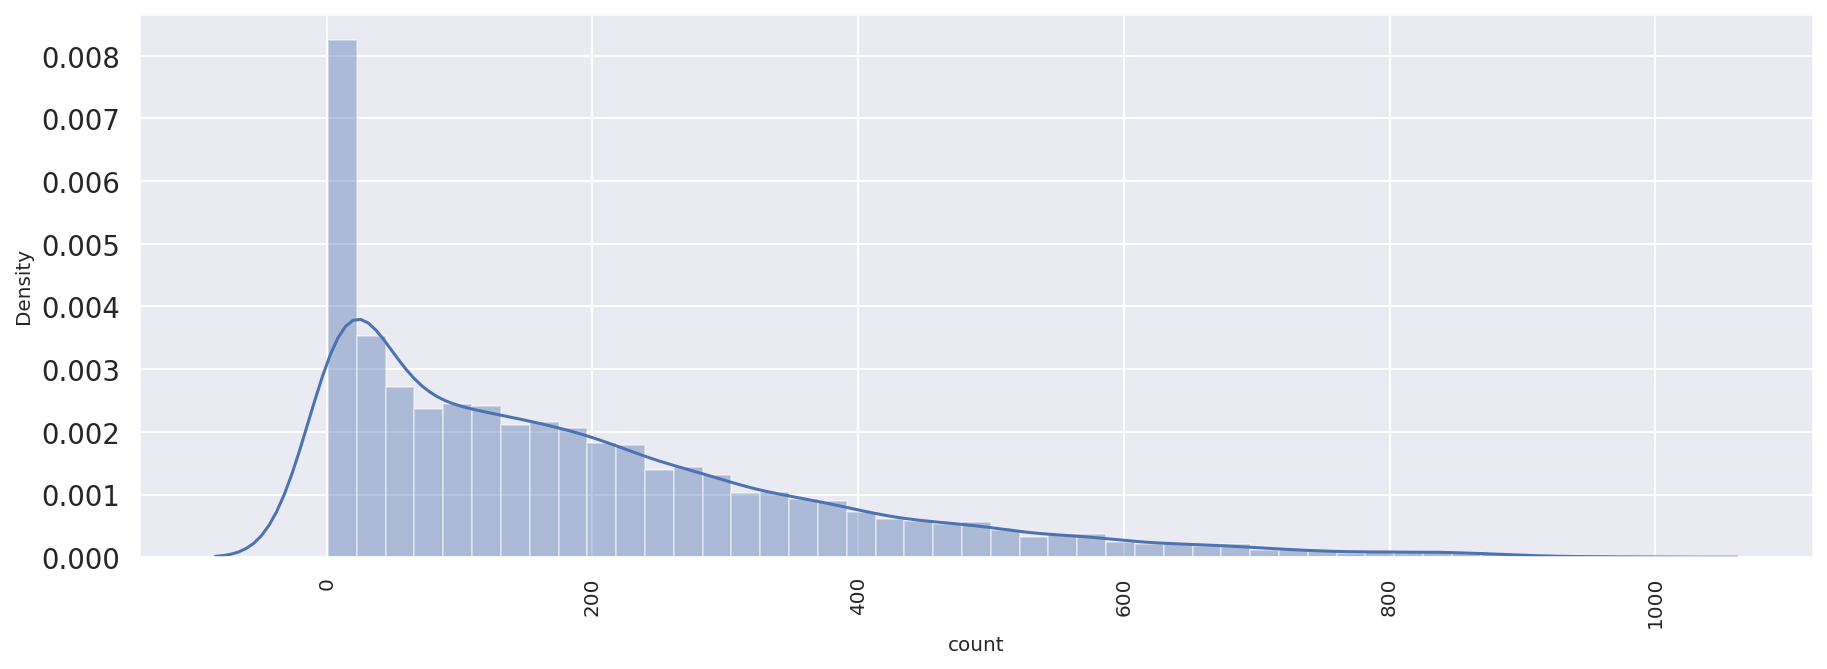

In [785]:
############################## 대여량 분포 시각화 ##############################

plt.figure(figsize=(15, 5))
plt.xticks(fontsize = 10,rotation =90)
sns.distplot(train["count"])

<div>
대부분의 자전거 대여량이 1~20(대)이다. 그런데 1000대인경우도 간혹보인다. 이렇게 데이터가 한쪽으루 치우쳐있으면 데이터 스케일링을 시켜주어야한다. 이번에는 로그변환을 진행해줄것이다. 로그변환을 사용하는 이유는 1~20대에 몰려있는 큰 수를 작게 만들어 왜도와 첨도를 줄이려는 목적이다.
</div>

In [786]:
############################## 대여량 로그화 ##############################

train["count_loged"] = np.log(train["count"] + 1)
train[["count", "count_loged"]].head(10)

,count,count_loged
0,16,2.83
1,40,3.71
2,32,3.50
3,13,2.64
4,1,0.69
5,1,0.69
6,2,1.10
7,3,1.39
8,8,2.20
9,14,2.71


Text(0.5, 1.0, '[ After Log Transformation ]')

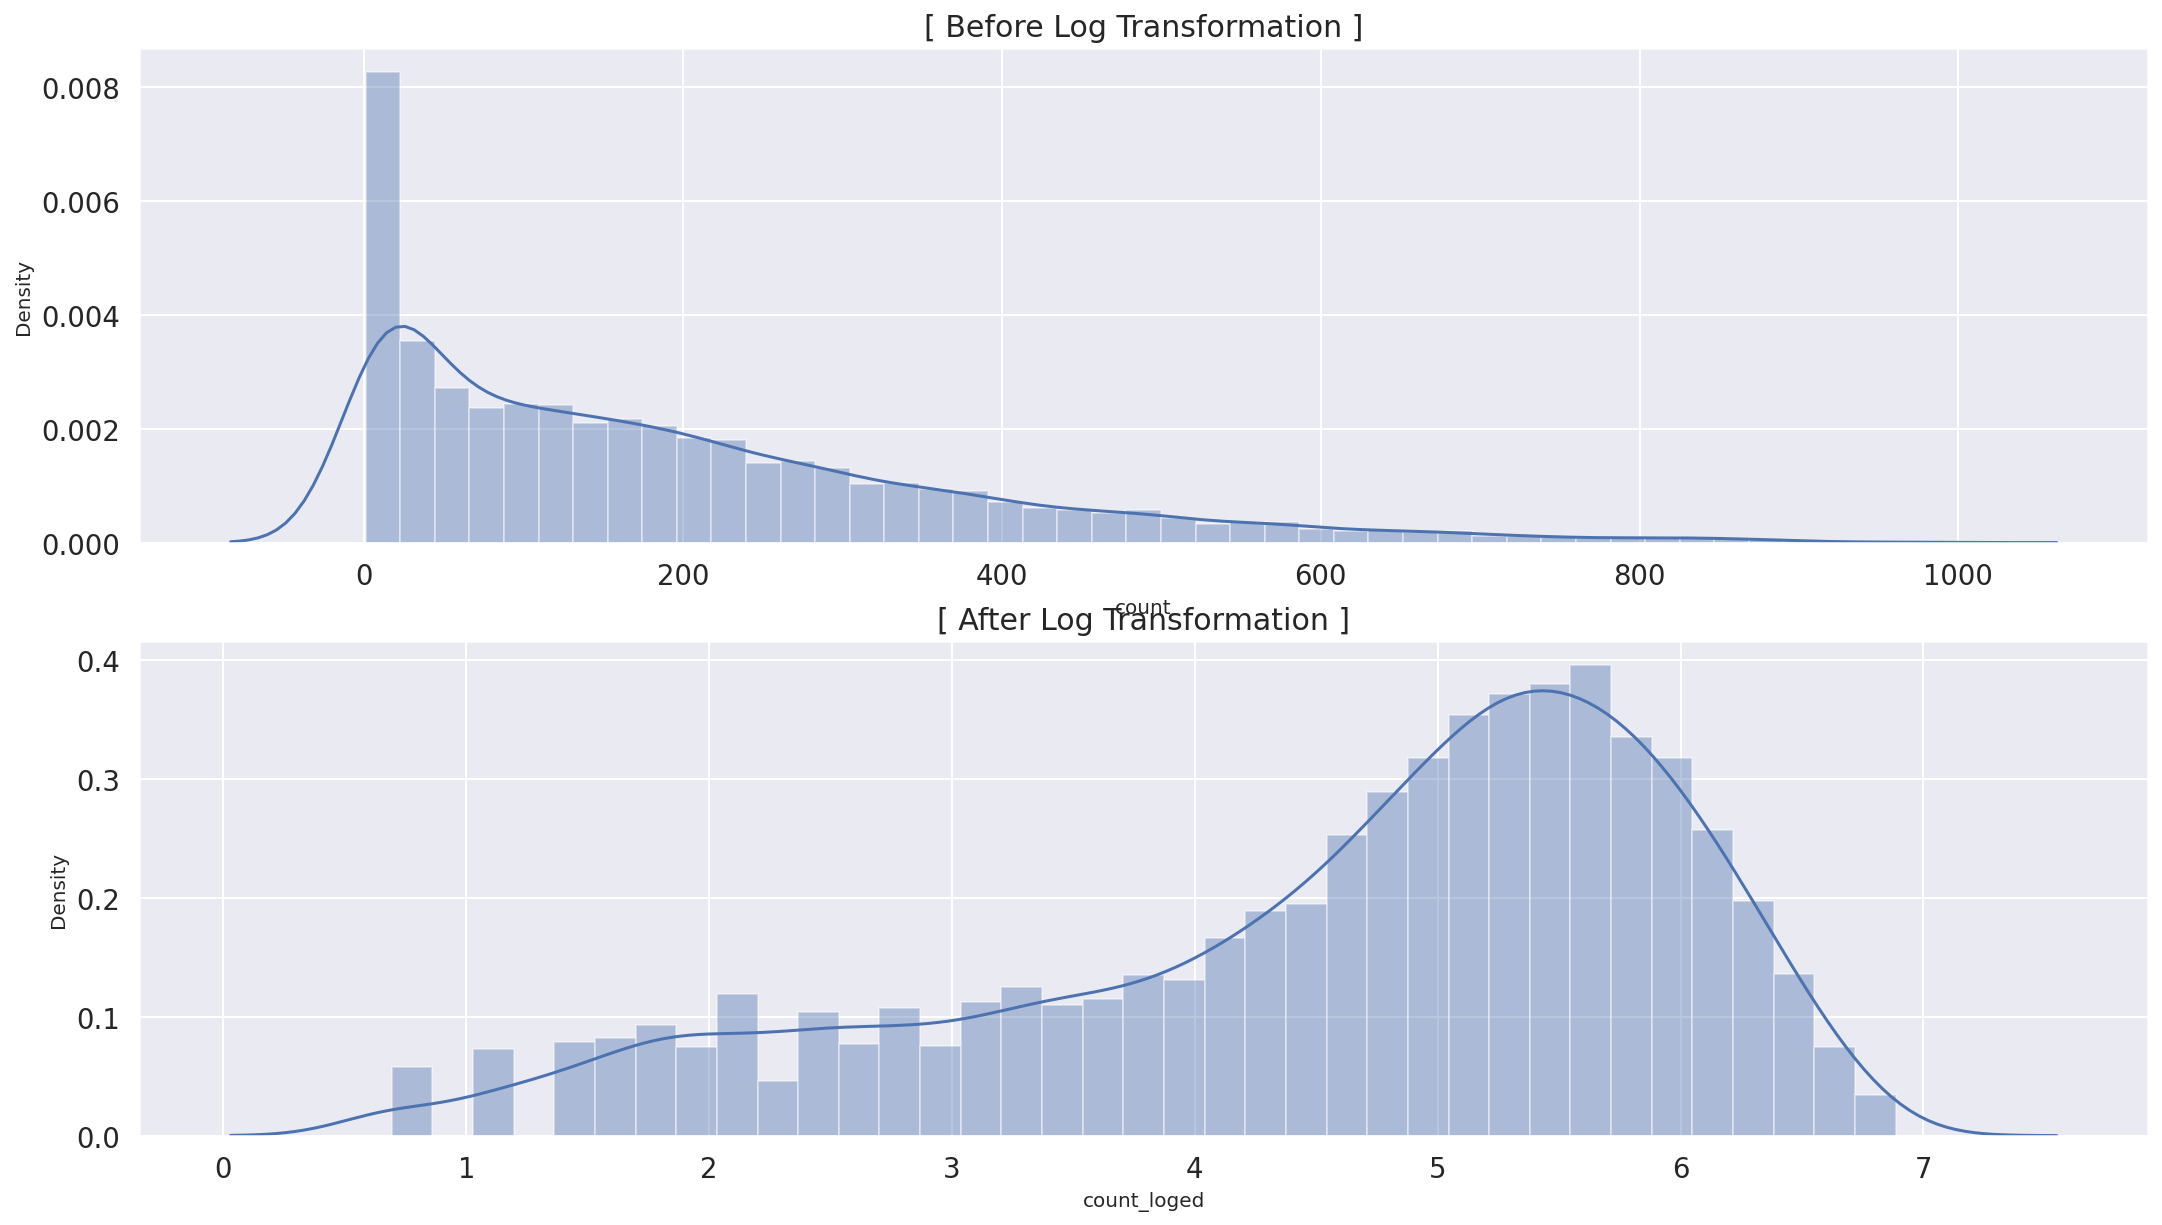

In [787]:
############################## count 로그화 전후 분포 시각화 ##############################

figure, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
figure.set_size_inches(18, 10)
sns.distplot(train["count"], ax=ax1)
sns.distplot(train["count_loged"], ax=ax2)
ax1.set_title("[ Before Log Transformation ]")
ax2.set_title("[ After Log Transformation ]")



<div>
로그변환이후 좀 더 정규분포에 가깝게 변한것을 알 수 있다. 모델에 학습시킬때도 이 로그화된 대여량으로 시키면 좋을것이다.
</div>

### 2-3. 모델 구현

#### 2-3-1. train/test 나누기


In [797]:
########################## eda로 선정한 feature와 로그화시킨 count 데이터로 train/test 나누기 ##############################
feature_names = ["season", "holiday", "workingday", "weather",
                 "temp", "atemp", "humidity", "windspeed",
                 "year", "hour"]
X = train[feature_names].values 
y = train["count_loged"].values 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)


#### **2-3-2. 모델 학습 및 예측**

In [798]:
############################## Linear Regression 학습 ##############################
lrg = LinearRegression()
lrg.fit(X_train, y_train)
y_pred = lrg.predict(X_test)
mse = mean_squared_error(np.exp(y_test), np.exp(y_pred))
rmse = mean_squared_error(np.exp(y_test), np.exp(y_pred), squared=False)

print(f' *mse : {mse}')
print(f' *rmse : {rmse}')

 *mse : 26269.413112694885
 *rmse : 162.07841655413247


In [ ]:
############################## cross_val_score 으로 교차검증 ##############################
lrg = LinearRegression()
lrg.fit(X_train, y_train)
rmse = mean_squared_error(np.exp(y_test), np.exp(y_pred), squared=False)
score = cross_val_score(lrg, X_train, y_train,
                        cv=20, scoring=rmse)
print("mse  {0:.5f}".format(score))

In [ ]:

############################## ) x축은 temp 또는 humidity로, y축은 count로 예측 결과 시각화 ##############################

figure, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
figure.set_size_inches(18, 10)
sns.scatterplot(X['temp'], np.exp(y_test), label='true', ax=ax1)
sns.scatterplot(X['temp'], np.exp(y_pred), label='pred', ax=ax1)
sns.scatterplot(X['humidity'], np.exp(y_test), label='true', ax=ax2)
sns.scatterplot(X['humidity'], np.exp(y_pred), label='pred', ax=ax2)
ax1.set_title("[ Temp True vs Predictions ]")
ax2.set_title("[ Humidity True vs Predictions]")




## **3. 회고** 


*   모델 성능을 향상시키는데는 적절한 모델선택 및 튜닝도 중요하지만, eda를 진행하면서 거기서 알게된 지식으로 새로운 feature도 생성해보고, 이상치를 처리해보는 한마디로 데이터를 뜯어보기 과정 또한 무척이나 중요하다는것을 느꼈다. 프로젝트를 진행하다보면 시간이 부족해서 평가기준을 충족하기에 급급한게 사실이지만 그래도 최대한 다양한 분석을 시도해보려는 노력을 가져보도록해야겠다. 

*   에포크와 이터레이션의 차이에 대해서 좀 더 알아봐야겠다. 학습률 업데이트하는과정에서 반복학습횟수를 지정했는데, lms에서는 이를 이터레이션이라는 개념으로 사용을 하였다. 그런데 관련 내용 검색을 해보니 대부분 에포크라는 단어를 사용하였다. 에포크와 이터레이션은 비슷한것같지만 다른 개념인것 같은데 이에 대해 좀 알아봐야겠다. 

*   제대로 된 학습률을 적용하는 방법을 찾아보다 지수기반 스케쥴링 이라는 것을 알게되었고 이를 이번 프로젝트에 적용해보았다. 그런데 똑같이 학습률도 설정을 해줘야하고 성능도 크게 좋은것같아보진않았다. 겉핥기로 알아본거라 이 내용에 대해서 좀 더 알아봐야할것같다.  


*   프로젝트 진행속도가 느려서 걱정이 많았는데, 많은 분들이 응원과 격려를 해주셨고 좋은 자료도 아낌없이 공유해주셔서 프로젝트 진행하는데 너무나도 큰 도움이 됐다..❤️ 다들 열심히 하셔서 그 모습에 나도 자극을 받아 열심히 하게 돼서 너~~무 좋았다. 나도 좋은 영향력을 줄 수 있는 사람이 되기 위해 열심히 해야겠다는 생각이 든다! ( 혹시 보고 계실 수도 있을 수도 있으니 감사의 인사 전합니다.. 헷 )
</div>